In [ ]:
%pip install torch-geometric
%pip install pynvml

In [1]:
import os
import math
import time
import copy
import psutil
import pynvml
import random
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as nn_utils

from torch.nn import Sequential, Linear, ReLU, Sigmoid, Tanh, Dropout, LeakyReLU
from torch.nn.modules.module import Module
from torch.distributions import normal, kl

import torch_geometric.utils as utils
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GCNConv, NNConv, global_mean_pool, BatchNorm, EdgePooling, TopKPooling, global_add_pool
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, mean_absolute_error, jaccard_score

from scipy.linalg import norm
from scipy.sparse.linalg import eigsh
from scipy.sparse import csgraph


if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
print(f'using {device}')

def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

set_seed(42)

using cuda


# Data Preprocessing

In [2]:
dataset_path = '/notebooks/dataset/'


def data_cleansing(dataset):
    # Replace negative values with 0
    dataset[dataset < 0] = 0
    
    # Replace NaN values with 0
    dataset = np.nan_to_num(dataset, nan=0)
    
    return dataset

def check_and_drop_invalid_graphs(graph_dataset):
    num_graphs, num_timepoints, num_nodes, _ = graph_dataset.shape
    num_dimensions = 1
    
    valid_graphs = []

    for i in range(num_graphs):
        is_valid = True
        for t in range(num_timepoints):
            adj_matrix = graph_dataset[i, t, :, :]
            num_edges = np.sum(adj_matrix > 0)
            if num_edges == 0:
                is_valid = False
                break
        
        if is_valid:
            valid_graphs.append(i)
    
    cleaned_dataset = graph_dataset[valid_graphs, :, :, :]
    
    return cleaned_dataset

def split_data(adj_data, features_data, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2, random_seed=None):
    assert adj_data.shape[0] == features_data.shape[0], "Adjacency and features data must have the same number of samples"
    assert np.isclose(train_ratio + val_ratio + test_ratio, 1.0), "The sum of train, val and test ratios must be 1"

    num_samples = adj_data.shape[0]
    indices = np.arange(num_samples)
    if random_seed is not None:
        np.random.seed(random_seed)
    np.random.shuffle(indices)

    train_end = int(train_ratio * num_samples)
    val_end = train_end + int(val_ratio * num_samples)

    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]

    adj_train = torch.tensor(adj_data[train_indices], dtype=torch.float32)
    adj_val = torch.tensor(adj_data[val_indices], dtype=torch.float32)
    adj_test = torch.tensor(adj_data[test_indices], dtype=torch.float32)

    features_train = torch.tensor(features_data[train_indices], dtype=torch.float32)
    features_val = torch.tensor(features_data[val_indices], dtype=torch.float32)
    features_test = torch.tensor(features_data[test_indices], dtype=torch.float32)

    return adj_train, adj_val, adj_test, features_train, features_val, features_test


## Simulated Dataset
simulated_adj = np.load(dataset_path + 'simulated_adj.npy')
simulated_adj = simulated_adj[:, :, :, :,0] #only take the domain 1
simulated_features = np.load(dataset_path + 'simulated_laplacian_features.npy')
simulated_features = simulated_features[:, :, :, :,0]
simulated_num_samples, simulated_num_time, simulated_num_nodes, simulated_num_features = simulated_features.shape 
print(f'Simulated Dataset: Number of Samples= {simulated_num_samples},  Number of Times= {simulated_num_time}, Number of Nodes= {simulated_num_nodes}, Number of Features= {simulated_num_features}')
simulated_adj_train, simulated_adj_val, simulated_adj_test, simulated_features_train, simulated_features_val, simulated_features_test = split_data(simulated_adj, simulated_features)

## OASIS Dataset
oasis = np.load(dataset_path + 'oasis_adj.npy')
oasis_cleaned = data_cleansing(oasis)
oasis_adj = check_and_drop_invalid_graphs(oasis_cleaned)
oasis_features = np.load(dataset_path + 'oasis_laplacian_features.npy') 
oasis_num_samples, oasis_num_time, oasis_num_nodes, oasis_num_features = oasis_features.shape 
print(f'OASIS Dataset: Number of Samples= {oasis_num_samples},  Number of Times= {oasis_num_time}, Number of Nodes= {oasis_num_nodes}, Number of Features= {oasis_num_features}')
oasis_adj_train, oasis_adj_val, oasis_adj_test, oasis_features_train, oasis_features_val, oasis_features_test = split_data(oasis_adj, oasis_features)

## EMCI-AD Dataset
emci = np.load(dataset_path + 'emci-ad_adj.npy')
emci_cleaned = data_cleansing(emci)
emci_adj = check_and_drop_invalid_graphs(emci_cleaned)
emci_features = np.load(dataset_path + 'emci-ad_laplacian_features.npy') 
emci_num_samples, emci_num_time, emci_num_nodes, emci_num_features = emci_features.shape 
print(f'EMCI-AD Dataset: Number of Samples= {emci_num_samples},  Number of Times= {emci_num_time}, Number of Nodes= {emci_num_nodes}, Number of Features= {emci_num_features}')
emci_adj_train, emci_adj_val, emci_adj_test, emci_features_train, emci_features_val, emci_features_test = split_data(emci_adj, emci_features)

## SLIM160 Dataset
slim160 = np.load(dataset_path + 'slim160_adj.npy')
slim160_cleaned = data_cleansing(slim160)
slim160_adj = check_and_drop_invalid_graphs(slim160_cleaned)
slim160_features = np.load(dataset_path + 'slim160_laplacian_features_8.npy') 
slim160_num_samples, slim160_num_time, slim160_num_nodes, slim160_num_features = slim160_features.shape 
print(f'SLIM160 Dataset: Number of Samples= {slim160_num_samples},  Number of Times= {slim160_num_time}, Number of Nodes = {slim160_num_nodes}, Number of Features = {slim160_num_features}')
slim160_adj_train, slim160_adj_val, slim160_adj_test, slim160_features_train, slim160_features_val, slim160_features_test = split_data(slim160_adj, slim160_features)

Simulated Dataset: Number of Samples= 100,  Number of Times= 3, Number of Nodes= 35, Number of Features= 8
OASIS Dataset: Number of Samples= 114,  Number of Times= 3, Number of Nodes= 35, Number of Features= 8
EMCI-AD Dataset: Number of Samples= 67,  Number of Times= 2, Number of Nodes= 35, Number of Features= 8
SLIM160 Dataset: Number of Samples= 109,  Number of Times= 3, Number of Nodes = 160, Number of Features = 8


In [3]:
def vectorize(M):
    return M[np.tril_indices(M.shape[0], k=-1)]

def create_edge_index_attribute(adj_matrix):
    rows, cols = adj_matrix.shape[0], adj_matrix.shape[1]
    edge_index = torch.zeros((2, rows * cols), dtype=torch.long)
    edge_attr = torch.zeros((rows * cols, 1), dtype=torch.float)
    counter = 0

    for src, attrs in enumerate(adj_matrix):
        for dest, attr in enumerate(attrs):
            edge_index[0][counter], edge_index[1][counter] = src, dest
            edge_attr[counter] = attr
            counter += 1

    return edge_index, edge_attr, rows, cols

def plot_heatmaps_each_timepoint(input_adj, ground_truth_adj, reconstructed_adj, residual_adj, time_point):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    ax[0].imshow(input_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[0].set_title(f'Input Graph at Time {time_point}')

    ax[1].imshow(ground_truth_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[1].set_title(f'Ground Truth Graph at Time {time_point+1}')

    ax[2].imshow(reconstructed_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[2].set_title(f'Generated Graph at Time {time_point+1}')

    ax[3].imshow(residual_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[3].set_title(f'Residual Graph at Time {time_point+1}')

    plt.show()

def plot_heatmaps_across_timepoints(input_adj, ground_truth_adj, reconstructed_adj, time_point):
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    cax0 = ax[0].imshow(input_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[0].set_title(f'Graph at Time {time_point}')
    fig.colorbar(cax0, ax=ax[0])

    cax1 = ax[1].imshow(ground_truth_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[1].set_title(f'Graph at Time {time_point+1}')
    fig.colorbar(cax1, ax=ax[1])

    cax2 = ax[2].imshow(reconstructed_adj.cpu().detach().numpy(), cmap='YlGnBu', interpolation='nearest')
    ax[2].set_title(f'Residual Graph between Time {time_point} and {time_point+1}')
    fig.colorbar(cax2, ax=ax[2])

    plt.show()


# Identity Mapper

In [4]:
def evaluate_identity(adj_test):
    num_test_samples = adj_test.shape[0]
    num_roi = adj_test.shape[2]
    num_time_points = adj_test.shape[1]

    # Initialize lists to store MAEs for each centrality measure
    mae_bc = []
    mae_ec = []
    mae_ns = []  # Node Strength
    mae_cc = []  # Clustering Coefficient
    frobenius_distances = []

    pred_1d_list = []
    gt_1d_list = []

    pred_matrices_all = []
    gt_matrices_all = []

    for i in range(num_test_samples):
        set_seed(42)
        
        # Predict adjacency matrix at time point t-1
        recon_adj_t_1 = adj_test[i, 0]
        pred_matrices_all.append(recon_adj_t_1.cpu().numpy())
        adj_t_gt_1 = adj_test[i, 1]  
        gt_matrices_all.append(adj_t_gt_1.cpu().numpy())
        
        pred_1d_list.append(vectorize(recon_adj_t_1.cpu().numpy()))
        gt_1d_list.append(vectorize(adj_t_gt_1.cpu().numpy()))

        if num_time_points > 2:
            # Predict adjacency matrix at time point t-1
            recon_adj_t_2 = adj_test[i, 1]
            pred_matrices_all.append(recon_adj_t_2.cpu().numpy())
            adj_t_gt_2 = adj_test[i, 2]  
            gt_matrices_all.append(adj_t_gt_2.cpu().numpy())

            pred_1d_list.append(vectorize(recon_adj_t_2).cpu().numpy())
            gt_1d_list.append(vectorize(adj_t_gt_2).cpu().numpy())
    
    for i in range(len(pred_matrices_all)):
        # Convert adjacency matrices to NetworkX graphs
        pred_graph = nx.from_numpy_array(pred_matrices_all[i])
        gt_graph = nx.from_numpy_array(gt_matrices_all[i])

        # Compute centrality measures
        pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
        pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight", max_iter=1000, tol=1e-3)
        pred_ns = dict(pred_graph.degree(weight="weight")).values()
        pred_cc = nx.clustering(pred_graph, weight="weight")

        gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
        gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight", max_iter=1000, tol=1e-3)
        gt_ns = dict(gt_graph.degree(weight="weight")).values()
        gt_cc = nx.clustering(gt_graph, weight="weight")

        # Convert centrality dictionaries to lists
        pred_bc_values = list(pred_bc.values())
        pred_ec_values = list(pred_ec.values())
        pred_ns_values = list(pred_ns)
        pred_cc_values = list(pred_cc.values())

        gt_bc_values = list(gt_bc.values())
        gt_ec_values = list(gt_ec.values())
        gt_ns_values = list(gt_ns)
        gt_cc_values = list(gt_cc.values())

        # Compute MAEs for centrality measures
        mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
        mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
        mae_ns.append(mean_absolute_error(pred_ns_values, gt_ns_values))
        mae_cc.append(mean_absolute_error(pred_cc_values, gt_cc_values))

        # Compute Frobenius distance
        frobenius_distances.append(norm(pred_matrices_all[i] - gt_matrices_all[i], 'fro'))
        
    # Compute average MAEs and distances
    avg_mae_bc = np.mean(mae_bc)
    avg_mae_ec = np.mean(mae_ec)
    avg_mae_ns = np.mean(mae_ns)
    avg_mae_cc = np.mean(mae_cc)
    avg_frobenius_distance = np.mean(frobenius_distances)

    # Concatenate flattened matrices
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)

    # Compute overall MAE
    mae = mean_absolute_error(pred_1d, gt_1d)

    return mae, avg_frobenius_distance, avg_mae_ns, avg_mae_cc, avg_mae_bc, avg_mae_ec

def evaluate_identity_cross_validation(adj_data, n_splits=3):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_mae = []
    fold_frobenius = []
    fold_mae_ns = []
    fold_mae_cc = []
    fold_mae_bc = []
    fold_mae_ec = []

    for fold, (train_index, test_index) in enumerate(kf.split(adj_data)):
        adj_test = adj_data[test_index]
        print(f"Evaluating fold {fold + 1}...")

        mae, frobenius_dist, mae_ns, mae_cc, mae_bc, mae_ec = evaluate_identity(adj_test)
        fold_mae.append(mae)
        fold_frobenius.append(frobenius_dist)
        fold_mae_ns.append(mae_ns)
        fold_mae_cc.append(mae_cc)
        fold_mae_bc.append(mae_bc)
        fold_mae_ec.append(mae_ec)

    print("3-Fold Cross Validation Results:")
    print(f"Average MAE: {np.mean(fold_mae):.4f} ± {np.std(fold_mae):.2f}")
    print(f"Average Frobenius distance: {np.mean(fold_frobenius):.4f} ± {np.std(fold_frobenius):.2f}")
    print(f"Average MAE node strength: {np.mean(fold_mae_ns):.4f} ± {np.std(fold_mae_ns):.2f}")
    print(f"Average MAE clustering coefficient: {np.mean(fold_mae_cc):.4f} ± {np.std(fold_mae_cc):.2f}")
    print(f"Average MAE betweenness centrality: {np.mean(fold_mae_bc):.4f} ± {np.std(fold_mae_bc):.2f}")
    print(f"Average MAE eigenvector centrality: {np.mean(fold_mae_ec):.4f} ± {np.std(fold_mae_ec):.2f}")


## Simulated

In [5]:
evaluate_identity_cross_validation(simulated_adj_test)

Evaluating fold 1...
Evaluating fold 2...
Evaluating fold 3...
3-Fold Cross Validation Results:
Average MAE: 0.0422 ± 0.00
Average Frobenius distance: 1.9740 ± 0.09
Average MAE node strength: 0.7076 ± 0.04
Average MAE clustering coefficient: 0.0581 ± 0.00
Average MAE betweenness centrality: 0.2722 ± 0.01
Average MAE eigenvector centrality: 0.0274 ± 0.00


## OASIS

In [13]:
evaluate_identity_cross_validation(oasis_adj_test)

Evaluating fold 1...
Evaluating fold 2...
Evaluating fold 3...
3-Fold Cross Validation Results:
Average MAE: 0.0523 ± 0.01
Average Frobenius distance: 2.6079 ± 0.65
Average MAE node strength: 0.9510 ± 0.26
Average MAE clustering coefficient: 0.0410 ± 0.01
Average MAE betweenness centrality: 0.0862 ± 0.00
Average MAE eigenvector centrality: 0.0233 ± 0.00


## EMCI-AD

In [14]:
evaluate_identity_cross_validation(emci_adj_test)

Evaluating fold 1...
Evaluating fold 2...
Evaluating fold 3...
3-Fold Cross Validation Results:
Average MAE: 0.0860 ± 0.01
Average Frobenius distance: 3.9414 ± 0.54
Average MAE node strength: 1.3765 ± 0.24
Average MAE clustering coefficient: 0.0101 ± 0.00
Average MAE betweenness centrality: 0.1051 ± 0.00
Average MAE eigenvector centrality: 0.0048 ± 0.00


## SLIM160

In [15]:
evaluate_identity_cross_validation(slim160_adj_test)

Evaluating fold 1...
Evaluating fold 2...
Evaluating fold 3...
3-Fold Cross Validation Results:
Average MAE: 0.1450 ± 0.00
Average Frobenius distance: 31.2550 ± 0.69
Average MAE node strength: 10.3607 ± 1.59
Average MAE clustering coefficient: 0.0562 ± 0.01
Average MAE betweenness centrality: 0.0286 ± 0.00
Average MAE eigenvector centrality: 0.0273 ± 0.00


# RBGM

In [7]:
def eucledian_distance(x, target_size):
  repeated_out = x.repeat(target_size,1,1)
  repeated_t = torch.transpose(repeated_out, 0, 1)
  diff = torch.abs(repeated_out - repeated_t)
  return torch.sum(diff, 2)

def frobenious_distance(test_sample,predicted):
  diff = torch.abs(test_sample - predicted)
  dif = diff*diff
  sum_of_all = diff.sum()
  d = torch.sqrt(sum_of_all)
  return d


## Model
class RNNCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_state):
        super(RNNCell, self).__init__()
        self.weight = nn.Linear(input_dim, hidden_dim, bias=True)
        self.weight_h = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.out = nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.tanh = Tanh()
        self.hidden_state = hidden_state
    
    def forward(self,x):
        h = self.hidden_state
        y = self.tanh(self.weight(x.to(device)) + self.weight_h(h))
        self.hidden_state = y.detach()
        return y

class RBGM(nn.Module):
    def __init__(self, conv_size, hidden_state_size):
        super(RBGM, self).__init__()
        shape = torch.Size((hidden_state_size, hidden_state_size))
        hidden_state = torch.rand(shape, device=device)
        self.conv_size = conv_size
        self.rnn = nn.Sequential(RNNCell(1,hidden_state_size, hidden_state), ReLU())
        self.gnn_conv = NNConv(self.conv_size, self.conv_size, self.rnn, aggr='mean', root_weight=True, bias = True)
        
    def forward(self, data):
        edge_index, edge_attr, _, _ = create_edge_index_attribute(data)
        x1 = F.relu(self.gnn_conv(data, edge_index.to(device), edge_attr.to(device)))
        x1 = eucledian_distance(x1, self.conv_size)
        return x1

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


def train_rbgm(model_1, model_2, train_adj, val_adj, num_epochs=200, lr=0.0001, 
               save_path='models/RBGM/rbgm_model', tp_c=10, patience=5, gradient_clip=1.0, step_size=50, gamma=0.1):
    
    # Initialize loss functions and optimizers
    mael = torch.nn.L1Loss().to(device)
    tp = torch.nn.MSELoss().to(device)

    optimizer_1 = optim.Adam(model_1.parameters(), lr=lr)
    optimizer_2 = optim.Adam(model_2.parameters(), lr=lr)

    # Learning rate schedulers
    scheduler_1 = torch.optim.lr_scheduler.StepLR(optimizer_1, step_size=step_size, gamma=gamma)
    scheduler_2 = torch.optim.lr_scheduler.StepLR(optimizer_2, step_size=step_size, gamma=gamma)

    # Track losses and resource usage
    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage_percent = []
    memory_usage = []
    gpu_usage = []
    gpu_usage_percent = []

    best_val_loss = float('inf')
    epochs_no_improve = 0

    model_1.to(device)
    model_2.to(device)
    process = psutil.Process()

    for epoch in range(num_epochs):
        total_loss_1, total_loss_2 = 0.0, 0.0
        tp_loss_1, tp_loss_2, gen_loss_1, gen_loss_2 = 0.0, 0.0, 0.0, 0.0
        
        set_seed(42)
        model_1.train()
        model_2.train()

        epoch_start_time = time.time()

        # Measure CPU and GPU usage before the epoch
        cpu_usage_before = psutil.cpu_percent(interval=None)
        memory_before = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_before = torch.cuda.memory_allocated(device)
            gpu_util_before = torch.cuda.utilization(device)
        else:
            gpu_usage_before = 0
            gpu_util_before = 0
        
        for i in range(train_adj.size(0)):
            data = train_adj[i]
            num_time_points = data.size(0)

            for t in range(num_time_points - 1):
                data_t = data[t]
                data_t_next = data[t + 1]
                
                # Time Point t
                optimizer_1.zero_grad()
                out_1 = model_1(data_t.to(device))
                
                tpl_1 = tp(out_1.sum(dim=-1), data_t_next.sum(dim=-1))
                tp_loss_1 += tpl_1.item()
                genl_1 = mael(out_1, data_t_next)
                gen_loss_1 += genl_1.item()
                
                loss_1 = genl_1 + tp_c * tpl_1
                total_loss_1 += loss_1.item()
                loss_1.backward()
                
                nn_utils.clip_grad_norm_(model_1.parameters(), gradient_clip)  # Gradient Clipping
                optimizer_1.step()
                
                if t < num_time_points - 2:
                    # Time Point t+1
                    optimizer_2.zero_grad()
                    out_2 = model_2(data_t_next.to(device))
                    
                    data_t_next_next = data[t + 2] if t + 2 < num_time_points else data_t_next
                    tpl_2 = tp(out_2.sum(dim=-1), data_t_next_next.sum(dim=-1))
                    tp_loss_2 += tpl_2.item()
                    
                    genl_2 = mael(out_2, data_t_next_next)
                    gen_loss_2 += genl_2.item()
                    
                    loss_2 = genl_2 + tp_c * tpl_2
                    total_loss_2 += loss_2.item()
                    loss_2.backward()
                    
                    nn_utils.clip_grad_norm_(model_2.parameters(), gradient_clip)  # Gradient Clipping
                    optimizer_2.step()
        
        scheduler_1.step()  # Step the learning rate schedulers
        scheduler_2.step()

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)

        # Measure CPU and GPU usage after the epoch
        cpu_usage_after = psutil.cpu_percent(interval=None)
        memory_after = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_after = torch.cuda.memory_allocated(device)
            gpu_util_after = torch.cuda.utilization(device)
        else:
            gpu_usage_after = 0
            gpu_util_after = 0

        # Calculate average CPU and GPU usage during the epoch
        cpu_usage_percent.append((cpu_usage_before + cpu_usage_after) / 2)
        memory_usage.append((memory_before + memory_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage.append((gpu_usage_before + gpu_usage_after) / 2 / (1024**3))  # Convert to GB
        gpu_usage_percent.append((gpu_util_before + gpu_util_after) / 2)

        # Compute average losses
        epoch_loss = (total_loss_1 + total_loss_2) / train_adj.size(0)
        epoch_gen_loss = (gen_loss_1 + gen_loss_2) / train_adj.size(0)
        epoch_tp_loss = (tp_loss_1 + tp_loss_2) / train_adj.size(0)
        training_loss.append(epoch_loss)
        
        print(f'Epoch {epoch + 1}:\n  Training -> Loss: {epoch_loss}, Generative Loss: {epoch_gen_loss}, Topological Loss: {epoch_tp_loss}')

        # Validation step
        model_1.eval()
        model_2.eval()
        val_loss_1, val_loss_2 = 0.0, 0.0
        val_tp_loss_1, val_tp_loss_2, val_gen_loss_1, val_gen_loss_2 = 0.0, 0.0, 0.0, 0.0
        
        with torch.no_grad():
            for i in range(val_adj.size(0)):
                data = val_adj[i]
                num_time_points = data.size(0)

                for t in range(num_time_points - 1):
                    data_t = data[t]
                    data_t_next = data[t + 1]

                    # Time Point t
                    out_1 = model_1(data_t.to(device))
                    
                    tpl_1 = tp(out_1.sum(dim=-1), data_t_next.sum(dim=-1))
                    val_tp_loss_1 += tpl_1.item()
                    genl_1 = mael(out_1, data_t_next)
                    val_gen_loss_1 += genl_1.item()
                    
                    loss_1 = genl_1 + tp_c * tpl_1
                    val_loss_1 += loss_1.item()
                    
                    if t < num_time_points - 2:
                        # Time Point t+1
                        out_2 = model_2(data_t_next.to(device))
                        
                        data_t_next_next = data[t + 2] if t + 2 < num_time_points else data_t_next
                        tpl_2 = tp(out_2.sum(dim=-1), data_t_next_next.sum(dim=-1))
                        val_tp_loss_2 += tpl_2.item()
                        
                        genl_2 = mael(out_2, data_t_next_next)
                        val_gen_loss_2 += genl_2.item()
                        
                        loss_2 = genl_2 + tp_c * tpl_2
                        val_loss_2 += loss_2.item()

        # Compute average validation losses
        val_loss = (val_loss_1 + val_loss_2) / val_adj.size(0)
        val_gen_loss = (val_gen_loss_1 + val_gen_loss_2) / val_adj.size(0)
        val_tp_loss = (val_tp_loss_1 + val_tp_loss_2) / val_adj.size(0)
        validation_loss.append(val_loss)

        print(f'  Validation -> Loss: {val_loss:.4f}, Generative Loss: {val_gen_loss:.4f}, Topological Loss: {val_tp_loss:.4f}')

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            total_epoch = epoch + 1
            torch.save(model_1.state_dict(), save_path + '_model_1.pth')
            torch.save(model_2.state_dict(), save_path + '_model_2.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                total_epoch = epoch + 1
                # print(f'Early stopping at epoch {epoch + 1}')
                break
        
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage_percent[-1]:.2f}%, Memory: {memory_usage[-1]:.2f}GB, GPU: {gpu_usage[-1]:.2f}GB, GPU Util: {gpu_usage_percent[-1]:.2f}%\n')

    # Plot the training and validation loss
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    avg_epoch_time = np.mean(epoch_time)
    avg_cpu_usage_percent = np.mean(cpu_usage_percent)
    avg_memory_usage = np.mean(memory_usage)
    avg_gpu_usage = np.mean(gpu_usage)
    avg_gpu_usage_percent = np.mean(gpu_usage_percent)
    total_training_time = np.sum(epoch_time)
    max_cpu_usage_percent = np.max(cpu_usage_percent)
    max_memory_usage = np.max(memory_usage)
    max_gpu_usage = np.max(gpu_usage)
    max_gpu_usage_percent = np.max(gpu_usage_percent)

    return total_epoch, total_training_time, avg_memory_usage, avg_gpu_usage, max_memory_usage, max_gpu_usage

def inference_rbgm(model_1, model_2, adj, sample_idx=0):
    # Load the saved model
    model_1.eval()
    model_2.eval()

    # Perform inference
    with torch.no_grad():
        # Generate graph at time point 1 given graph at time point 0
        recon_adj_1 = model_1(adj[sample_idx, 0])
        residual_adj_1 = recon_adj_1 - adj[sample_idx, 1]
        mse_residual_adj_1 = np.mean(np.square(residual_adj_1.cpu().detach().numpy()))
        print("Mean Squared Error between predicted (t1) and ground truth graphs (t0): ", mse_residual_adj_1)
        plot_heatmaps_each_timepoint(adj[sample_idx, 0], adj[sample_idx, 1], recon_adj_1, residual_adj_1, 0)

        if adj.shape[1] > 2:  # Check if there is a second time point
            # Generate graph at time point 2 given graph at time point 1
            recon_adj_2 = model_2(adj[sample_idx, 1])
            residual_adj_2 = recon_adj_2 - adj[sample_idx, 2]
            mse_residual_adj_2 = np.mean(np.square(residual_adj_2.cpu().detach().numpy()))
            print("Mean Squared Error between predicted (t2) and ground truth graphs (t1): ", mse_residual_adj_2)
            plot_heatmaps_each_timepoint(adj[sample_idx, 1], adj[sample_idx, 2], recon_adj_2, residual_adj_2, 1)

            # Plot residual graph between the output of the first time point and the second time point
            residual_between_gt = adj[sample_idx, 2] - adj[sample_idx, 1]
            mse_residual_between_gt = np.mean(np.square(residual_between_gt.cpu().detach().numpy()))
            print("Mean Squared Error between ground truth graphs: ", mse_residual_between_gt)
            plot_heatmaps_across_timepoints(adj[sample_idx, 1], adj[sample_idx, 2], residual_between_gt, 1)

            residual_between_outputs = recon_adj_2 - recon_adj_1
            mse_residual_between_outputs = np.mean(np.square(residual_between_outputs.cpu().detach().numpy()))
            print("Mean Squared Error between generated graphs: ", mse_residual_between_outputs)
            plot_heatmaps_across_timepoints(recon_adj_1, recon_adj_2, residual_between_outputs, 1)

def evaluate_rbgm(model_1, model_2, adj_test):
    num_test_samples = adj_test.shape[0]

    # Initialize lists to store MAEs for each centrality measure
    mae_bc = []
    mae_ec = []
    mae_ns = []  # Node Strength
    mae_cc = []  # Clustering Coefficient
    frobenius_distances = []

    pred_1d_list = []
    gt_1d_list = []

    pred_matrices_all = []
    gt_matrices_all = []

    with torch.no_grad():
        for i in range(num_test_samples):
            for t in range(1, adj_test.shape[1]):
                set_seed(42)
                if t == 1:
                    # Predict adjacency matrix at time point 1
                    recon_adj_t_1 = model_1(adj_test[i, t-1])
                    pred_matrices_all.append(recon_adj_t_1.cpu().numpy())
                    adj_t_gt_1 = adj_test[i, t]
                    gt_matrices_all.append(adj_t_gt_1.cpu().numpy())

                    pred_1d_list.append(vectorize(recon_adj_t_1.cpu().numpy()))
                    gt_1d_list.append(vectorize(adj_t_gt_1.cpu().numpy()))

                if t == 2:
                    # Predict adjacency matrix at time point 2
                    recon_adj_t_2 = model_2(adj_test[i, t-1])
                    pred_matrices_all.append(recon_adj_t_2.cpu().numpy())
                    adj_t_gt_2 = adj_test[i, t]
                    gt_matrices_all.append(adj_t_gt_2.cpu().numpy())

                    pred_1d_list.append(vectorize(recon_adj_t_2.cpu().numpy()))
                    gt_1d_list.append(vectorize(adj_t_gt_2.cpu().numpy()))

    for i in range(len(pred_matrices_all)):
        # Convert adjacency matrices to NetworkX graphs
        pred_graph = nx.from_numpy_array(pred_matrices_all[i])
        gt_graph = nx.from_numpy_array(gt_matrices_all[i])

        # Compute centrality measures
        pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
        pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight", max_iter=1000, tol=1e-3)
        pred_ns = dict(pred_graph.degree(weight="weight")).values()
        pred_cc = nx.clustering(pred_graph, weight="weight")

        gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
        gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight", max_iter=1000, tol=1e-3)
        gt_ns = dict(gt_graph.degree(weight="weight")).values()
        gt_cc = nx.clustering(gt_graph, weight="weight")

        # Convert centrality dictionaries to lists
        pred_bc_values = list(pred_bc.values())
        pred_ec_values = list(pred_ec.values())
        pred_ns_values = list(pred_ns)
        pred_cc_values = list(pred_cc.values())

        gt_bc_values = list(gt_bc.values())
        gt_ec_values = list(gt_ec.values())
        gt_ns_values = list(gt_ns)
        gt_cc_values = list(gt_cc.values())

        # Compute MAEs for centrality measures
        mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
        mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
        mae_ns.append(mean_absolute_error(pred_ns_values, gt_ns_values))
        mae_cc.append(mean_absolute_error(pred_cc_values, gt_cc_values))

        # Compute Frobenius distance
        frobenius_distances.append(norm(pred_matrices_all[i] - gt_matrices_all[i], 'fro'))
        
    # Compute average MAEs and distances
    avg_mae_bc = np.mean(mae_bc)
    avg_mae_ec = np.mean(mae_ec)
    avg_mae_ns = np.mean(mae_ns)
    avg_mae_cc = np.mean(mae_cc)
    avg_frobenius_distance = np.mean(frobenius_distances)

    # Concatenate flattened matrices
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)

    # Compute overall MAE
    mae = mean_absolute_error(pred_1d, gt_1d)


    metrics = {
        "mae": mae,
        "avg_frobenius_distance": avg_frobenius_distance,
        "avg_mae_ns": avg_mae_ns,
        "avg_mae_cc": avg_mae_cc,
        "avg_mae_bc": avg_mae_bc,
        "avg_mae_ec": avg_mae_ec
    }

    return metrics

def train_test_cv_rbgm(model_1, model_2, features, adj, num_folds=3, lr=0.001, num_epochs=200, patience=5, step_size=50, gamma=0.1, 
                       save_path='models/rbgm_model', tp_c=10, gradient_clip=1.0):
    
    features = torch.tensor(features, dtype=torch.float32)
    adj = torch.tensor(adj, dtype=torch.float32)

    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    fold_results = {
        "mae": [],
        "frobenius_distance": [],
        "mae_ns": [],
        "mae_cc": [],
        "mae_bc": [],
        "mae_ec": [],
        "epochs": [],
        "training_times": [],
        "avg_memory_usage": [],
        "avg_gpu_usage": [],
        "max_memory_usage": [],
        "max_gpu_usage": []
    }

    for fold, (train_val_idx, test_idx) in enumerate(kfold.split(features)):
        print(f"\nFold {fold+1}/{num_folds}")
        
        train_val_features, test_features = features[train_val_idx], features[test_idx]
        train_val_adj, test_adj = adj[train_val_idx], adj[test_idx]

        val_split = int(len(train_val_features) * 0.1)
        
        train_features = train_val_features[:-val_split]
        val_features = train_val_features[-val_split:]
        train_adj = train_val_adj[:-val_split]
        val_adj = train_val_adj[-val_split:]

        # Initialize model copies for this fold
        model_1_copy = copy.deepcopy(model_1)
        model_2_copy = copy.deepcopy(model_2)

        # Train the models
        total_epoch, total_training_time, avg_memory_usage, avg_gpu_usage, max_memory_usage, max_gpu_usage = train_rbgm(model_1_copy.to(device), model_2_copy.to(device), train_adj.to(device), val_adj.to(device), 
                   num_epochs=num_epochs, lr=lr, save_path=save_path, tp_c=tp_c, patience=patience, 
                   gradient_clip=gradient_clip, step_size=step_size, gamma=gamma)

        # Evaluate the models
        metrics = evaluate_rbgm(model_1_copy.to(device), model_2_copy.to(device), test_adj.to(device))

        # Collect metrics for the fold
        fold_results["mae"].append(metrics["mae"])
        fold_results["frobenius_distance"].append(metrics["avg_frobenius_distance"])
        fold_results["mae_ns"].append(metrics["avg_mae_ns"])
        fold_results["mae_cc"].append(metrics["avg_mae_cc"])
        fold_results["mae_bc"].append(metrics["avg_mae_bc"])
        fold_results["mae_ec"].append(metrics["avg_mae_ec"])
        fold_results["epochs"].append(total_epoch)
        fold_results["training_times"].append(total_training_time)
        fold_results["avg_memory_usage"].append(avg_memory_usage)
        fold_results["avg_gpu_usage"].append(avg_gpu_usage)
        fold_results["max_memory_usage"].append(max_memory_usage)
        fold_results["max_gpu_usage"].append(max_gpu_usage)

        print(f"Fold {fold+1} Results:")
        print(f"   MAE: {metrics['mae']}")
        print(f"   Average Frobenius distance: {metrics['avg_frobenius_distance']}")
        print(f"   Average MAE node strength: {metrics['avg_mae_ns']}")
        print(f"   Average MAE clustering coefficient: {metrics['avg_mae_cc']}")
        print(f"   Average MAE betweenness centrality: {metrics['avg_mae_bc']}")
        print(f"   Average MAE eigenvector centrality: {metrics['avg_mae_ec']}")

    avg_metrics = {metric: np.mean(fold_results[metric]) for metric in fold_results}
    std_metrics = {metric: np.std(fold_results[metric]) for metric in fold_results}

    print("\nCross-Validation Results:")
    for metric in avg_metrics:
        avg_value = avg_metrics[metric]
        std_value = std_metrics[metric]
        print(f"{metric}: Mean = {avg_value:.4f} ± {std_value:.2f}")

    return avg_metrics, std_metrics

## Simulated

RBGM(
  (rnn): Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  )
  (gnn_conv): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  ))
)
Total number of trainable parameters: 6014820


Fold 1/3
Epoch 1:
  Training -> Loss: 9005.944708251953, Generative Loss: 1.3389126047492028, Topological Loss: 900.4605840047201
  Validation -> Loss: 3916.9834, Generative Loss: 0.9618, Topological Loss: 391.6022
Time: 19.17s, CPU: 31.25%, Memory: 3.00GB, GPU: 0.09GB, GPU Util: 2.00%

Epoch 2:
  Training -> Loss: 28

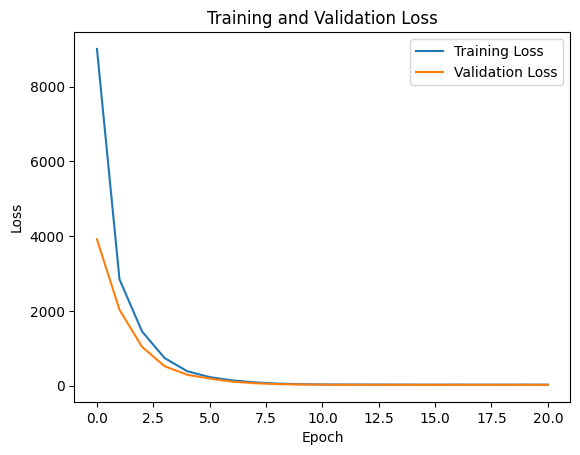

Fold 1 Results:
   MAE: 0.037365108728408813
   Average Frobenius distance: 1.6994110345840454
   Average MAE node strength: 0.7252637918848095
   Average MAE clustering coefficient: 0.16388472714334953
   Average MAE betweenness centrality: 0.24352634101769055
   Average MAE eigenvector centrality: 0.023728068444006753

Fold 2/3
Epoch 1:
  Training -> Loss: 8778.327256499744, Generative Loss: 1.3215675932950661, Topological Loss: 877.700565900959
  Validation -> Loss: 3556.0668, Generative Loss: 0.9097, Topological Loss: 355.5157
Time: 16.63s, CPU: 27.55%, Memory: 3.26GB, GPU: 0.10GB, GPU Util: 2.00%

Epoch 2:
  Training -> Loss: 2734.7999627785603, Generative Loss: 0.7842143593264408, Topological Loss: 273.40157458821284
  Validation -> Loss: 1779.7656, Generative Loss: 0.6330, Topological Loss: 177.9133
Time: 18.25s, CPU: 23.70%, Memory: 3.27GB, GPU: 0.12GB, GPU Util: 4.50%

Epoch 3:
  Training -> Loss: 1373.7181057539142, Generative Loss: 0.53962797219636, Topological Loss: 137.317

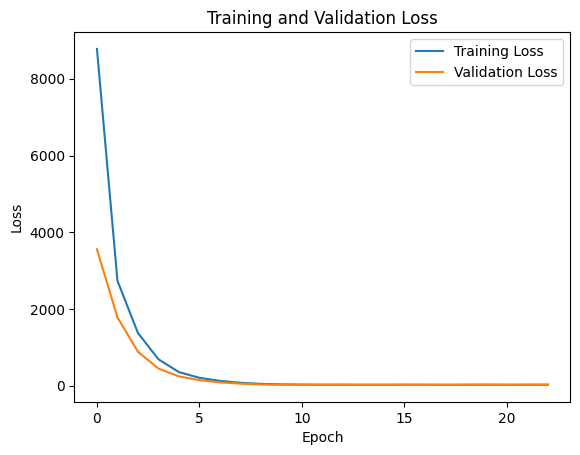

Fold 2 Results:
   MAE: 0.037279389798641205
   Average Frobenius distance: 1.707910180091858
   Average MAE node strength: 0.6765681507637105
   Average MAE clustering coefficient: 0.16769095167805914
   Average MAE betweenness centrality: 0.2277646595828414
   Average MAE eigenvector centrality: 0.024320518941417076

Fold 3/3
Epoch 1:
  Training -> Loss: 8411.10472932409, Generative Loss: 1.3024198901457864, Topological Loss: 840.9802264854557
  Validation -> Loss: 3553.6943, Generative Loss: 0.9095, Topological Loss: 355.2785
Time: 16.79s, CPU: 29.70%, Memory: 3.27GB, GPU: 0.10GB, GPU Util: 1.50%

Epoch 2:
  Training -> Loss: 2609.6166742043415, Generative Loss: 0.7671854019653602, Topological Loss: 260.884946385368
  Validation -> Loss: 1916.0522, Generative Loss: 0.6585, Topological Loss: 191.5394
Time: 18.10s, CPU: 30.05%, Memory: 3.27GB, GPU: 0.12GB, GPU Util: 4.50%

Epoch 3:
  Training -> Loss: 1320.475520024534, Generative Loss: 0.5296043824465548, Topological Loss: 131.994591

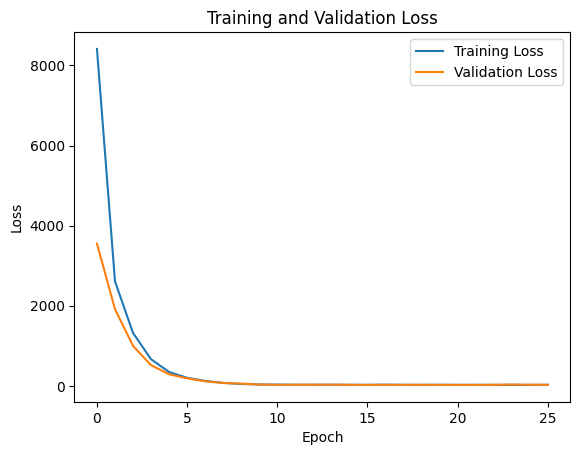

Fold 3 Results:
   MAE: 0.03762281313538551
   Average Frobenius distance: 1.7160155773162842
   Average MAE node strength: 0.658642407127779
   Average MAE clustering coefficient: 0.19288280811409006
   Average MAE betweenness centrality: 0.24815033451397084
   Average MAE eigenvector centrality: 0.024037913193208454

Cross-Validation Results:
mae: Mean = 0.0374, Std = 0.00
frobenius_distance: Mean = 1.7078, Std = 0.01
mae_ns: Mean = 0.6868, Std = 0.03
mae_cc: Mean = 0.1748, Std = 0.01
mae_bc: Mean = 0.2398, Std = 0.01
mae_ec: Mean = 0.0240, Std = 0.00
epochs: Mean = 23.3333, Std = 2.05
training_times: Mean = 409.5338, Std = 35.94
avg_memory_usage: Mean = 3.2601, Std = 0.01
avg_gpu_usage: Mean = 0.1175, Std = 0.00
max_memory_usage: Mean = 3.2647, Std = 0.01
max_gpu_usage: Mean = 0.1183, Std = 0.00


In [6]:
conv_size = simulated_adj_train.shape[2]
hidden_size = conv_size*conv_size
rbgm_simulated_model_1 = RBGM(conv_size, hidden_size).to(device)
rbgm_simulated_model_2 = RBGM(conv_size, hidden_size).to(device)

print(rbgm_simulated_model_1)
print(f"Total number of trainable parameters: {(rbgm_simulated_model_1.count_parameters())*2}\n")

# Train model 
set_seed(42)
avg_metrics, std_metrics = train_test_cv_rbgm(rbgm_simulated_model_1, rbgm_simulated_model_2, simulated_features, simulated_adj,
            num_epochs=100, lr=0.001, step_size=50, gamma=0.1,
            save_path="models/rbgm_simulated")

## OASIS-2

RBGM(
  (rnn): Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  )
  (gnn_conv): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  ))
)
Total number of trainable parameters: 6014820


Fold 1/3
Epoch 1:
  Training -> Loss: 280027.78486390045, Generative Loss: 1.8252994180589481, Topological Loss: 28002.596553747204
  Validation -> Loss: 5027.1599, Generative Loss: 1.0754, Topological Loss: 502.6085
Time: 19.32s, CPU: 20.40%, Memory: 3.28GB, GPU: 0.14GB, GPU Util: 2.00%

Epoch 2:
  Training -> Loss: 

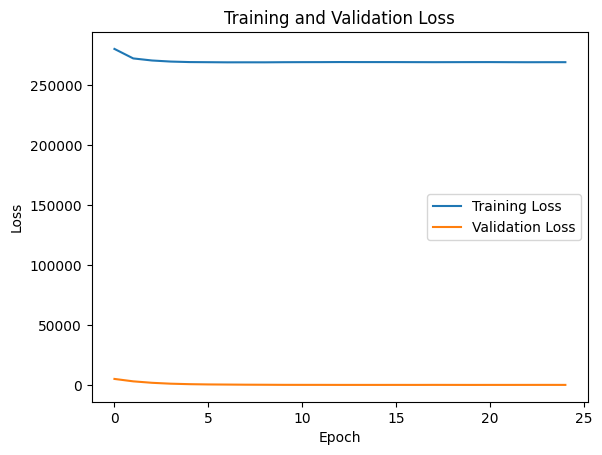

Fold 1 Results:
   MAE: 0.06322068721055984
   Average Frobenius distance: 3.0429744720458984
   Average MAE node strength: 1.4034549817224504
   Average MAE clustering coefficient: 0.13666141159210413
   Average MAE betweenness centrality: 0.08184570777188684
   Average MAE eigenvector centrality: 0.024245140478418914

Fold 2/3
Epoch 1:
  Training -> Loss: 283301.6453645126, Generative Loss: 1.9468133112658625, Topological Loss: 28329.969428131546
  Validation -> Loss: 6124.6411, Generative Loss: 1.1646, Topological Loss: 612.3476
Time: 18.61s, CPU: 24.05%, Memory: 3.28GB, GPU: 0.14GB, GPU Util: 1.50%

Epoch 2:
  Training -> Loss: 273832.35730489093, Generative Loss: 1.347041708835657, Topological Loss: 27383.101710747982
  Validation -> Loss: 3716.4212, Generative Loss: 0.8994, Topological Loss: 371.5522
Time: 20.08s, CPU: 34.00%, Memory: 3.28GB, GPU: 0.15GB, GPU Util: 4.00%

Epoch 3:
  Training -> Loss: 271322.5428879779, Generative Loss: 1.065330849501534, Topological Loss: 27132.1

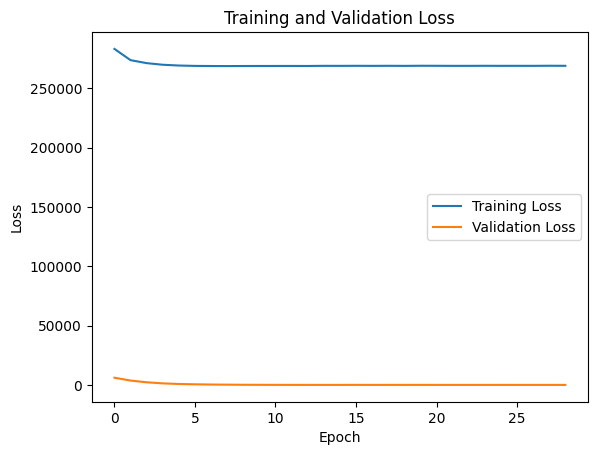

Fold 2 Results:
   MAE: 0.05183175206184387
   Average Frobenius distance: 2.334057092666626
   Average MAE node strength: 1.0907598801849303
   Average MAE clustering coefficient: 0.14792530281373314
   Average MAE betweenness centrality: 0.08311859393041451
   Average MAE eigenvector centrality: 0.0233976956400387

Fold 3/3
Epoch 1:
  Training -> Loss: 15398.639891693558, Generative Loss: 1.6402803868919178, Topological Loss: 1539.6999545442886
  Validation -> Loss: 15706.4583, Generative Loss: 1.4405, Topological Loss: 1570.5018
Time: 22.19s, CPU: 34.65%, Memory: 3.29GB, GPU: 0.14GB, GPU Util: 2.50%

Epoch 2:
  Training -> Loss: 6332.771007371985, Generative Loss: 1.0519678074380625, Topological Loss: 633.1719003207442
  Validation -> Loss: 9093.9535, Generative Loss: 1.1079, Topological Loss: 909.2846
Time: 21.48s, CPU: 34.45%, Memory: 3.29GB, GPU: 0.15GB, GPU Util: 4.00%

Epoch 3:
  Training -> Loss: 3615.412141551142, Generative Loss: 0.7713526413924452, Topological Loss: 361.464

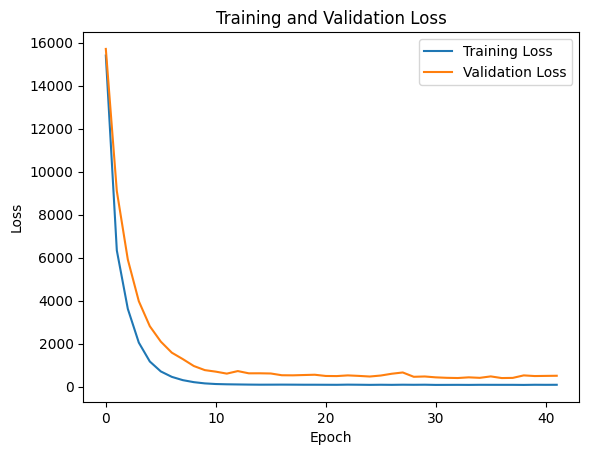

Fold 3 Results:
   MAE: 0.17363914847373962
   Average Frobenius distance: 20.139698028564453
   Average MAE node strength: 5.184434141749171
   Average MAE clustering coefficient: 0.14217293250051022
   Average MAE betweenness centrality: 0.08308617912056655
   Average MAE eigenvector centrality: 0.023587636669595114

Cross-Validation Results:
mae: Mean = 0.0962 ± 0.05
frobenius_distance: Mean = 8.5056 ± 8.23
mae_ns: Mean = 2.5595 ± 1.86
mae_cc: Mean = 0.1423 ± 0.00
mae_bc: Mean = 0.0827 ± 0.00
mae_ec: Mean = 0.0237 ± 0.00
epochs: Mean = 32.0000 ± 7.26
training_times: Mean = 642.3085 ± 148.94
avg_memory_usage: Mean = 3.2820 ± 0.01
avg_gpu_usage: Mean = 0.1516 ± 0.00
max_memory_usage: Mean = 3.2821 ± 0.01
max_gpu_usage: Mean = 0.1522 ± 0.00


In [8]:
conv_size = oasis_adj_train.shape[2]
hidden_size = conv_size*conv_size
rbgm_oasis_model_1 = RBGM(conv_size, hidden_size).to(device)
rbgm_oasis_model_2 = RBGM(conv_size, hidden_size).to(device)

print(rbgm_oasis_model_1)
print(f"Total number of trainable parameters: {(rbgm_oasis_model_1.count_parameters())*2}\n")

avg_metrics, std_metrics = train_test_cv_rbgm(rbgm_oasis_model_1, rbgm_oasis_model_2, oasis_features, oasis_adj, 
                        num_folds=3, lr=0.001, num_epochs=100, step_size=50, gamma=0.5, 
                        save_path="models/rbgm_oasis")

## EMCI-AD

RBGM(
  (rnn): Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  )
  (gnn_conv): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): RNNCell(
      (weight): Linear(in_features=1, out_features=1225, bias=True)
      (weight_h): Linear(in_features=1225, out_features=1225, bias=True)
      (out): Linear(in_features=1225, out_features=1225, bias=True)
      (tanh): Tanh()
    )
    (1): ReLU()
  ))
)
Total number of trainable parameters: 6014820


Fold 1/3


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1:
  Training -> Loss: 603281.579296875, Generative Loss: 5.03486819267273, Topological Loss: 60327.65517578125
  Validation -> Loss: 105072.2285, Generative Loss: 2.7640, Topological Loss: 10506.9463
Time: 3.90s, CPU: 31.15%, Memory: 3.30GB, GPU: 0.16GB, GPU Util: 2.00%

Epoch 2:
  Training -> Loss: 92110.73271484375, Generative Loss: 2.5735661387443542, Topological Loss: 9210.815911865235
  Validation -> Loss: 49695.9692, Generative Loss: 1.8756, Topological Loss: 4969.4093
Time: 3.84s, CPU: 29.70%, Memory: 3.31GB, GPU: 0.17GB, GPU Util: 3.00%

Epoch 3:
  Training -> Loss: 52970.6154296875, Generative Loss: 1.9620773404836656, Topological Loss: 5296.8653015136715
  Validation -> Loss: 35971.3452, Generative Loss: 1.5878, Topological Loss: 3596.9758
Time: 4.19s, CPU: 31.40%, Memory: 3.31GB, GPU: 0.17GB, GPU Util: 4.00%

Epoch 4:
  Training -> Loss: 37466.21301269531, Generative Loss: 1.651081994175911, Topological Loss: 3746.4561920166016
  Validation -> Loss: 37359.6606, Genera

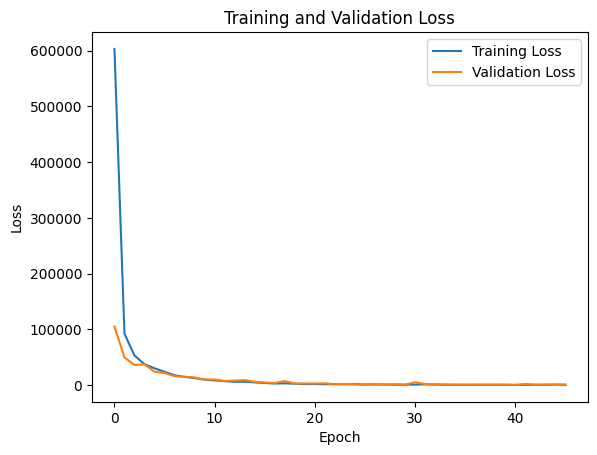

Fold 1 Results:
   MAE: 0.3600555658340454
   Average Frobenius distance: 16.6903018951416
   Average MAE node strength: 11.138350339834238
   Average MAE clustering coefficient: 0.07691991344771414
   Average MAE betweenness centrality: 0.09665931802880894
   Average MAE eigenvector centrality: 0.009767249320037145

Fold 2/3


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1:
  Training -> Loss: 620351.7657202744, Generative Loss: 4.842546983463008, Topological Loss: 62034.69177543826
  Validation -> Loss: 131780.1758, Generative Loss: 3.0781, Topological Loss: 13177.7100
Time: 3.92s, CPU: 30.90%, Memory: 3.31GB, GPU: 0.16GB, GPU Util: 2.50%

Epoch 2:
  Training -> Loss: 82093.65834603658, Generative Loss: 2.4407059070540638, Topological Loss: 8209.12177258003
  Validation -> Loss: 90597.1318, Generative Loss: 2.5302, Topological Loss: 9059.4603
Time: 3.16s, CPU: 16.70%, Memory: 3.31GB, GPU: 0.17GB, GPU Util: 4.50%

Epoch 3:
  Training -> Loss: 59130.00252477134, Generative Loss: 2.096098132249786, Topological Loss: 5912.79062261814
  Validation -> Loss: 75778.3838, Generative Loss: 2.3373, Topological Loss: 7577.6046
Time: 3.27s, CPU: 17.00%, Memory: 3.31GB, GPU: 0.17GB, GPU Util: 5.00%

Epoch 4:
  Training -> Loss: 42179.47284679878, Generative Loss: 1.7460909384052927, Topological Loss: 4217.772600871761
  Validation -> Loss: 42009.6460, Generat

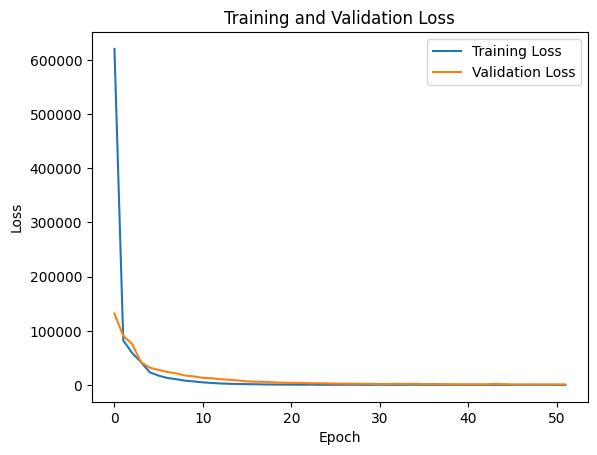

Fold 2 Results:
   MAE: 0.1997847557067871
   Average Frobenius distance: 8.645519256591797
   Average MAE node strength: 5.325289504817466
   Average MAE clustering coefficient: 0.07661316354515227
   Average MAE betweenness centrality: 0.09088256790319432
   Average MAE eigenvector centrality: 0.009600243673894343

Fold 3/3


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1:
  Training -> Loss: 594508.0299161585, Generative Loss: 4.912640216873913, Topological Loss: 59450.3115115282
  Validation -> Loss: 132503.5312, Generative Loss: 3.0303, Topological Loss: 13250.0498
Time: 3.94s, CPU: 32.00%, Memory: 3.31GB, GPU: 0.16GB, GPU Util: 2.50%

Epoch 2:
  Training -> Loss: 85117.52753429877, Generative Loss: 2.4882780458869003, Topological Loss: 8511.503918159298
  Validation -> Loss: 69564.2188, Generative Loss: 2.2005, Topological Loss: 6956.2022
Time: 4.67s, CPU: 34.15%, Memory: 3.31GB, GPU: 0.17GB, GPU Util: 3.00%

Epoch 3:
  Training -> Loss: 57816.10008574695, Generative Loss: 2.0626437256975874, Topological Loss: 5781.403769888529
  Validation -> Loss: 53010.2412, Generative Loss: 1.9034, Topological Loss: 5300.8338
Time: 3.85s, CPU: 37.15%, Memory: 3.31GB, GPU: 0.17GB, GPU Util: 4.00%

Epoch 4:
  Training -> Loss: 40184.09972846799, Generative Loss: 1.7003122277376128, Topological Loss: 4018.2398890053355
  Validation -> Loss: 41696.2388, Gene

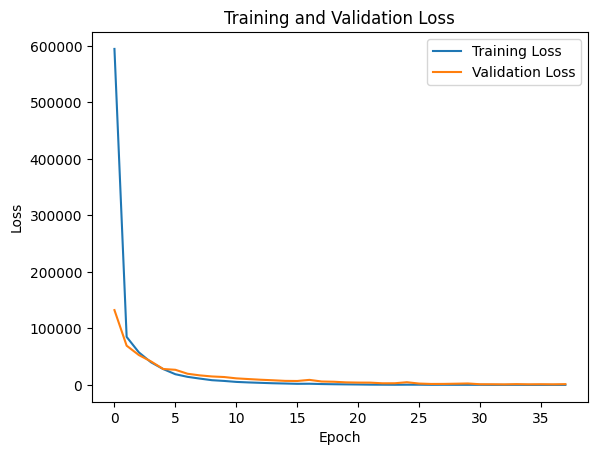

Fold 3 Results:
   MAE: 0.1950681358575821
   Average Frobenius distance: 8.75990104675293
   Average MAE node strength: 5.143588734768624
   Average MAE clustering coefficient: 0.06835806441916054
   Average MAE betweenness centrality: 0.0869416471822889
   Average MAE eigenvector centrality: 0.008490036497253427

Cross-Validation Results:
mae: Mean = 0.2516 ± 0.08
frobenius_distance: Mean = 11.3652 ± 3.77
mae_ns: Mean = 7.2024 ± 2.78
mae_cc: Mean = 0.0740 ± 0.00
mae_bc: Mean = 0.0915 ± 0.00
mae_ec: Mean = 0.0093 ± 0.00
epochs: Mean = 45.3333 ± 5.73
training_times: Mean = 176.4213 ± 21.69
avg_memory_usage: Mean = 3.3103 ± 0.00
avg_gpu_usage: Mean = 0.1681 ± 0.00
max_memory_usage: Mean = 3.3105 ± 0.00
max_gpu_usage: Mean = 0.1683 ± 0.00


In [9]:
conv_size = emci_adj_train.shape[2]
hidden_size = conv_size*conv_size
rbgm_emci_model_1 = RBGM(conv_size, hidden_size).to(device)
rbgm_emci_model_2 = RBGM(conv_size, hidden_size).to(device)

print(rbgm_emci_model_1)
print(f"Total number of trainable parameters: {(rbgm_emci_model_1.count_parameters())*2}\n")

# Train model 
set_seed(42)
avg_metrics, std_metrics = train_test_cv_rbgm(rbgm_emci_model_1, rbgm_emci_model_2, emci_features, emci_adj,
            num_epochs=100, lr=0.001, step_size=50, gamma=0.1,
            save_path="models/rbgm_emci")

## SLIM160

In [78]:
conv_size = slim160_adj_train.shape[2]
hidden_size = conv_size*conv_size
rbgm_slim160_model_1 = RBGM(conv_size, hidden_size).to(device)
rbgm_slim160_model_2 = RBGM(conv_size, hidden_size).to(device)

print(rbgm_slim160_model_1)
print(rbgm_slim160_model_2)
print(f"Total number of trainable parameters: {(rbgm_slim160_model_1.count_parameters())*2}\n")

# Train model 
train_rbgm(rbgm_slim160_model_1, rbgm_slim160_model_2, slim160_adj_train.to(device), slim160_adj_val.to(device),
            num_epochs=100, lr=0.001, step_size=50, gamma=0.1,
            save_path="models/rbgm_slim160")

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.44 GiB. GPU 0 has a total capacty of 15.89 GiB of which 398.69 MiB is free. Process 1232900 has 15.50 GiB memory in use. Of the allocated memory 14.82 GiB is allocated by PyTorch, and 78.49 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# EvoGraph

In [6]:
class EvoGenerator(nn.Module):
    def __init__(self, conv_size, hidden_size):
        super(EvoGenerator, self).__init__()
        self.conv_size = conv_size
        self.hidden_size = hidden_size

        lin = Sequential(Linear(1, self.hidden_size), ReLU())
        self.conv1 = NNConv(self.conv_size, self.conv_size, lin, aggr='mean', root_weight=True, bias=True)
        self.conv11 = BatchNorm(self.conv_size, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)

        lin = Sequential(Linear(1, self.conv_size), ReLU())
        self.conv2 = NNConv(self.conv_size, 1, lin, aggr='mean', root_weight=True, bias=True)
        self.conv22 = BatchNorm(1, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)

        lin = Sequential(Linear(1, self.conv_size), ReLU())
        self.conv3 = NNConv(1, self.conv_size, lin, aggr='mean', root_weight=True, bias=True)
        self.conv33 = BatchNorm(self.conv_size, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x1 = torch.sigmoid(self.conv11(self.conv1(x, edge_index, edge_attr)))
        x1 = F.dropout(x1, training=self.training)
        
        x1 = (x1 + x1.T) / 2.0
        x1.fill_diagonal_(fill_value=0)
        x2 = torch.sigmoid(self.conv22(self.conv2(x1, edge_index, edge_attr)))
        x2 = F.dropout(x2, training=self.training)

        x3 = torch.cat([torch.sigmoid(self.conv33(self.conv3(x2, edge_index, edge_attr))), x1], dim=1)
        x4 = x3[:, 0:self.conv_size]
        x5 = x3[:, self.conv_size:self.conv_size*2]

        x6 = (x4 + x5) / 2
        x6 = (x6 + x6.T) / 2.0
        x6.fill_diagonal_(fill_value=0)
        return x6
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

class EvoDiscriminator(nn.Module):
    def __init__(self, conv_size, hidden_size):
        super(EvoDiscriminator, self).__init__()
        self.conv_size = conv_size
        self.hidden_size = hidden_size
        
        lin = Sequential(Linear(2, self.hidden_size), ReLU())
        self.conv1 = NNConv(self.conv_size, self.conv_size, lin, aggr='mean', root_weight=True, bias=True)
        self.conv11 = BatchNorm(self.conv_size, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)

        lin = Sequential(Linear(2, self.conv_size), ReLU())
        self.conv2 = NNConv(self.conv_size, 1, lin, aggr='mean', root_weight=True, bias=True)
        self.conv22 = BatchNorm(1, eps=1e-03, momentum=0.1, affine=True, track_running_stats=True)

    def forward(self, data, data_to_translate):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        edge_attr_data_to_translate = data_to_translate.edge_attr

        edge_attr_data_to_translate_reshaped = edge_attr_data_to_translate.view(self.hidden_size, 1)

        gen_input = torch.cat((edge_attr, edge_attr_data_to_translate_reshaped), -1)
        x = F.relu(self.conv11(self.conv1(x, edge_index, gen_input)))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv22(self.conv2(x, edge_index, gen_input)))

        return torch.sigmoid(x)
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


def train_evograph(generator_1, discriminator_1, generator_2, discriminator_2, train_adj, val_adj,
                   num_epochs=500, lr_g=0.01, lr_d=0.0002, save_path='models/EvoGraph/evograph_model',
                   tp_c=0.00, g_c=2.0, i_c=2.0, kl_c=0.001, patience=5, gradient_clip=1.0, step_size=50, gamma=0.1):

    adversarial_loss = torch.nn.BCELoss().to(device)
    identity_loss = torch.nn.L1Loss().to(device)
    msel = torch.nn.MSELoss().to(device)
    mael = torch.nn.L1Loss().to(device)
    tp = torch.nn.MSELoss().to(device)

    optimizer_G1 = torch.optim.AdamW(generator_1.parameters(), lr=lr_g, betas=(0.5, 0.999), weight_decay=0.0)
    optimizer_D1 = torch.optim.AdamW(discriminator_1.parameters(), lr=lr_d, betas=(0.5, 0.999), weight_decay=0.0)
    optimizer_G2 = torch.optim.AdamW(generator_2.parameters(), lr=lr_g, betas=(0.5, 0.999), weight_decay=0.0)
    optimizer_D2 = torch.optim.AdamW(discriminator_2.parameters(), lr=lr_d, betas=(0.5, 0.999), weight_decay=0.0)

    scheduler_G1 = torch.optim.lr_scheduler.StepLR(optimizer_G1, step_size=step_size, gamma=gamma)
    scheduler_D1 = torch.optim.lr_scheduler.StepLR(optimizer_D1, step_size=step_size, gamma=gamma)
    scheduler_G2 = torch.optim.lr_scheduler.StepLR(optimizer_G2, step_size=step_size, gamma=gamma)
    scheduler_D2 = torch.optim.lr_scheduler.StepLR(optimizer_D2, step_size=step_size, gamma=gamma)

    num_nodes = train_adj.shape[2]
    real_label = torch.ones(num_nodes, 1).to(device)
    fake_label = torch.zeros(num_nodes, 1).to(device)

    training_loss = []
    validation_loss = []
    epoch_time = []
    cpu_usage_percent = []
    memory_usage = []
    gpu_usage = []
    gpu_usage_percent = []

    best_val_loss = float('inf')
    epochs_no_improve = 0

    generator_1.to(device)
    discriminator_1.to(device)
    generator_2.to(device)
    discriminator_2.to(device)
    process = psutil.Process()

    for epoch in range(num_epochs):
        r1, f1, d1, g1, mse_l1, mae_l1 = 0, 0, 0, 0, 0, 0
        r2, f2, d2, g2, mse_l2, mae_l2 = 0, 0, 0, 0, 0, 0

        generator_1.train()
        discriminator_1.train()
        generator_2.train()
        discriminator_2.train()

        epoch_start_time = time.time()

        # Measure CPU and GPU usage before the epoch
        cpu_usage_before = psutil.cpu_percent(interval=None)
        memory_before = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_before = torch.cuda.memory_allocated(device)
            gpu_util_before = torch.cuda.utilization(device)
        else:
            gpu_usage_before = 0
            gpu_util_before = 0

        for i in range(train_adj.size(0)):
            data = train_adj.to(device)
            num_time_points = data[i].size(0)

            edge_idx_t0, edge_att_t0, _, _ = create_edge_index_attribute(data[i, 0])
            data_t0 = Data(x=data[i, 0], edge_attr=edge_att_t0, edge_index=edge_idx_t0).to(device)
            edge_idx_t1, edge_att_t1, _, _ = create_edge_index_attribute(data[i, 1])
            data_t1 = Data(x=data[i, 1], edge_attr=edge_att_t1, edge_index=edge_idx_t1).to(device)

            # 1st Part Training
            ## Discriminator
            optimizer_D1.zero_grad()
            fake_t1 = generator_1(data_t0).detach()
            edge_idx_f1, edge_att_f1, _, _ = create_edge_index_attribute(fake_t1)
            fake_data_t1 = Data(x=fake_t1, edge_attr=edge_att_f1, edge_index=edge_idx_f1).to(device)

            real_loss_1 = adversarial_loss(discriminator_1(data_t1, data_t0), real_label)
            fake_loss_1 = adversarial_loss(discriminator_1(fake_data_t1, data_t0), fake_label)
            loss_D1 = torch.mean(real_loss_1 + fake_loss_1) / 2
            r1 += real_loss_1.item()
            f1 += fake_loss_1.item()
            d1 += loss_D1.item()

            loss_D1.backward(retain_graph=True)
            optimizer_D1.step()
            
            ## Generator
            optimizer_G1.zero_grad()
            fake_data_t1.x = generator_1(data_t0)
            gan_loss_1 = torch.mean(adversarial_loss(discriminator_1(fake_data_t1, data_t0), real_label))
            tp_loss_1 = tp(fake_data_t1.x.sum(dim=-1), data_t1.x.sum(dim=-1))
            kl_loss_1 = kl.kl_divergence(normal.Normal(fake_data_t1.x.mean(dim=1), fake_data_t1.x.std(dim=1)),
                                         normal.Normal(data_t1.x.mean(dim=1), data_t1.x.std(dim=1))).sum()
            

            loss_G1 = (i_c * identity_loss(generator_1(data_t1), data_t1.x)) + (g_c * gan_loss_1) + (kl_c * kl_loss_1) + (tp_c * tp_loss_1)
            g1 += loss_G1.item()
            
            loss_G1.backward(retain_graph=True)
            optimizer_G1.step()

            mse_l1 += msel(generator_1(data_t0), data_t1.x).item()
            mae_l1 += mael(generator_1(data_t0), data_t1.x).item()

            if num_time_points == 3:
                edge_idx_t2, edge_att_t2, _, _ = create_edge_index_attribute(data[i, 2])
                data_t2 = Data(x=data[i, 2], edge_attr=edge_att_t2, edge_index=edge_idx_t2).to(device)

                # 2nd Part Training
                ## Discriminator
                optimizer_D2.zero_grad()
                fake_data_t1.x = fake_data_t1.x.detach()

                fake_t2 = generator_2(fake_data_t1).detach()
                edge_idx_f2, edge_att_f2, _, _ = create_edge_index_attribute(fake_t2)
                fake_data_t2 = Data(x=fake_t2, edge_attr=edge_att_f2, edge_index=edge_idx_f2).to(device)

                real_loss_2 = adversarial_loss(discriminator_2(data_t2, fake_data_t1), real_label)
                fake_loss_2 = adversarial_loss(discriminator_2(fake_data_t2, fake_data_t1), fake_label)
                loss_D2 = torch.mean(real_loss_2 + fake_loss_2) / 2
                r2 += real_loss_2.item()
                f2 += fake_loss_2.item()
                d2 += loss_D2.item()

                loss_D2.backward(retain_graph=True)
                optimizer_D2.step()

                optimizer_G2.zero_grad()
                fake_data_t2.x = generator_2(fake_data_t1)
                gan_loss_2 = torch.mean(adversarial_loss(discriminator_2(fake_data_t2, fake_data_t1), real_label))
                tp_loss_2 = tp(fake_data_t2.x.sum(dim=-1), data_t2.x.sum(dim=-1))
                kl_loss_2 = kl.kl_divergence(normal.Normal(fake_data_t2.x.mean(dim=1), fake_data_t2.x.std(dim=1)),
                                             normal.Normal(data_t2.x.mean(dim=1), data_t2.x.std(dim=1))).sum()
                
                loss_G2 = (i_c * identity_loss(generator_2(data_t2), data_t2.x)) + (g_c * gan_loss_2) + (kl_c * kl_loss_2) + (tp_c * tp_loss_2)
                g2 += loss_G2.item()
                loss_G2.backward(retain_graph=True)
                optimizer_G2.step()

                mse_l2 += msel(generator_2(data_t0), data_t2.x).item()
                mae_l2 += mael(generator_2(data_t0), data_t2.x).item()

        scheduler_G1.step()
        scheduler_D1.step()
        scheduler_G2.step()
        scheduler_D2.step()

        epoch_end_time = time.time()
        epoch_time.append(epoch_end_time - epoch_start_time)

        # Measure CPU and GPU usage after the epoch
        cpu_usage_after = psutil.cpu_percent(interval=None)
        memory_after = process.memory_info().rss
        if torch.cuda.is_available():
            gpu_usage_after = torch.cuda.memory_allocated(device)
            gpu_util_after = torch.cuda.utilization(device)
        else:
            gpu_usage_after = 0
            gpu_util_after = 0

        cpu_usage_percent.append((cpu_usage_before + cpu_usage_after) / 2)
        memory_usage.append((memory_before + memory_after) / 2 / (1024**3))
        gpu_usage.append((gpu_usage_before + gpu_usage_after) / 2 / (1024**3))
        gpu_usage_percent.append((gpu_util_before + gpu_util_after) / 2)

        d1 /= train_adj.size(0)
        g1 /= train_adj.size(0)
        d2 /= train_adj.size(0) if num_time_points == 3 else 1
        g2 /= train_adj.size(0) if num_time_points == 3 else 1

        training_loss.append(d1 + g1 + d2 + g2)

        print(f'Epoch {epoch + 1}:\n  Training -> D1 Loss: {d1:.5f}, G1 Loss: {g1:.5f}, D2 Loss: {d2:.5f}, G2 Loss: {g2:.5f}')

        # Validation step
        generator_1.eval()
        discriminator_1.eval()
        generator_2.eval()
        discriminator_2.eval()
        val_loss_1, val_loss_2 = 0.0, 0.0
        val_loss_d1, val_loss_d2, val_loss_g1, val_loss_g2 = 0.0, 0.0, 0.0, 0.0
        
        with torch.no_grad():
            for i in range(val_adj.size(0)):
                data = val_adj[i]
                num_time_points = data.size(0)

                edge_idx_t, edge_att_t, _, _ = create_edge_index_attribute(data[0])
                data_t0 = Data(x=data[0], edge_attr=edge_att_t, edge_index=edge_idx_t).to(device)
                edge_idx_t1, edge_att_t1, _, _ = create_edge_index_attribute(data[1])
                data_t1 = Data(x=data[1], edge_attr=edge_att_t1, edge_index=edge_idx_t1).to(device)

                fake_t1 = generator_1(data_t0).detach()
                edge_idx_f1, edge_att_f1, _, _ = create_edge_index_attribute(fake_t1)
                fake_data_t1 = Data(x=fake_t1, edge_attr=edge_att_f1, edge_index=edge_idx_f1).to(device)

                real_loss_1 = adversarial_loss(discriminator_1(data_t1, data_t0), real_label)
                fake_loss_1 = adversarial_loss(discriminator_1(fake_data_t1, data_t0), fake_label)
                loss_D1 = torch.mean(real_loss_1 + fake_loss_1) / 2
                val_loss_d1 += loss_D1.item()

                ## Generator
                fake_data_t1.x = generator_1(data_t0)
                gan_loss_1 = torch.mean(adversarial_loss(discriminator_1(fake_data_t1, data_t0), real_label))
                tp_loss_1 = tp(fake_data_t1.x.sum(dim=-1), data_t1.x.sum(dim=-1))
                kl_loss_1 = kl.kl_divergence(normal.Normal(fake_data_t1.x.mean(dim=1), fake_data_t1.x.std(dim=1)),
                                            normal.Normal(data_t1.x.mean(dim=1), data_t1.x.std(dim=1))).sum()
                

                loss_G1 = (i_c * identity_loss(generator_1(data_t1), data_t1.x)) + (g_c * gan_loss_1) + (kl_c * kl_loss_1) + (tp_c * tp_loss_1)
                val_loss_g1 += loss_G1.item()
                val_loss_1 = val_loss_d1 + val_loss_g1

                if num_time_points == 3:
                    edge_idx_t2, edge_att_t2, _, _ = create_edge_index_attribute(data[2])
                    data_t2 = Data(x=data[2], edge_attr=edge_att_t2, edge_index=edge_idx_t2).to(device)

                    fake_data_t1.x = fake_data_t1.x.detach()

                    fake_t2 = generator_2(fake_data_t1).detach()
                    edge_idx_f2, edge_att_f2, _, _ = create_edge_index_attribute(fake_t2)
                    fake_data_t2 = Data(x=fake_t2, edge_attr=edge_att_f2, edge_index=edge_idx_f2).to(device)

                    real_loss_2 = adversarial_loss(discriminator_2(data_t2, fake_data_t1), real_label)
                    fake_loss_2 = adversarial_loss(discriminator_2(fake_data_t2, fake_data_t1), fake_label)
                    loss_D2 = torch.mean(real_loss_2 + fake_loss_2) / 2
                    val_loss_d2 += loss_D2.item()

                    fake_data_t2.x = generator_2(fake_data_t1)
                    gan_loss_2 = torch.mean(adversarial_loss(discriminator_2(fake_data_t2, fake_data_t1), real_label))
                    tp_loss_2 = tp(fake_data_t2.x.sum(dim=-1), data_t2.x.sum(dim=-1))
                    kl_loss_2 = kl.kl_divergence(normal.Normal(fake_data_t2.x.mean(dim=1), fake_data_t2.x.std(dim=1)),
                                                normal.Normal(data_t2.x.mean(dim=1), data_t2.x.std(dim=1))).sum()
                    
                    loss_G2 = (i_c * identity_loss(generator_2(data_t2), data_t2.x)) + (g_c * gan_loss_2) + (kl_c * kl_loss_2) + (tp_c * tp_loss_2)
                    val_loss_g2 += loss_G2.item()
                    val_loss_2 = val_loss_d2 + val_loss_g2
                

        val_loss = (val_loss_1 + val_loss_2) / val_adj.size(0)
        validation_loss.append(val_loss)

        print(f'  Validation -> Loss: {val_loss:.4f}')
        print(f'Time: {epoch_time[-1]:.2f}s, CPU: {cpu_usage_percent[-1]:.2f}%, Memory: {memory_usage[-1]:.2f}GB, GPU: {gpu_usage[-1]:.2f}GB, GPU Util: {gpu_usage_percent[-1]:.2f}%')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            total_epoch = epoch + 1
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                total_epoch = epoch + 1
                print(f'Early stopping at epoch {epoch + 1}')
                break

    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    avg_epoch_time = np.mean(epoch_time)
    avg_cpu_usage_percent = np.mean(cpu_usage_percent)
    avg_memory_usage = np.mean(memory_usage)
    avg_gpu_usage = np.mean(gpu_usage)
    avg_gpu_usage_percent = np.mean(gpu_usage_percent)
    total_training_time = np.sum(epoch_time)
    max_cpu_usage_percent = np.max(cpu_usage_percent)
    max_memory_usage = np.max(memory_usage)
    max_gpu_usage = np.max(gpu_usage)
    max_gpu_usage_percent = np.max(gpu_usage_percent)

    return total_epoch, total_training_time, avg_memory_usage, avg_gpu_usage, max_memory_usage, max_gpu_usage

def inference_evograph(model_1, model_2, adj, sample_idx=0):
    model_1.eval()
    model_2.eval()

    with torch.no_grad():
        # Generate graph at time point 1 given graph at time point 0
        edge_idx_t0, edge_att_t0, _, _ = create_edge_index_attribute(adj[sample_idx, 0])
        data_t0 = Data(x=adj[sample_idx, 0], edge_attr=edge_att_t0, edge_index=edge_idx_t0).to(device)
        recon_adj_1 = model_1(data_t0)
        residual_adj_1 = recon_adj_1 - adj[sample_idx, 1]
        mse_residual_adj_1 = np.mean(np.square(residual_adj_1.cpu().detach().numpy()))
        print("Mean Squared Error between predicted (t1) and ground truth graphs (t0): ", mse_residual_adj_1)
        plot_heatmaps_each_timepoint(adj[sample_idx, 0], adj[sample_idx, 1], recon_adj_1, residual_adj_1, 0)

        if adj.shape[1] > 2:  # Check if there is a second time point
            edge_idx_t1, edge_att_t1, _, _ = create_edge_index_attribute(adj[sample_idx, 1])
            data_t1 = Data(x=adj[sample_idx, 1], edge_attr=edge_att_t1, edge_index=edge_idx_t1).to(device)
            recon_adj_2 = model_2(data_t1)
            residual_adj_2 = recon_adj_2 - adj[sample_idx, 2]
            mse_residual_adj_2 = np.mean(np.square(residual_adj_2.cpu().detach().numpy()))
            print("Mean Squared Error between predicted (t2) and ground truth graphs (t1): ", mse_residual_adj_2)
            plot_heatmaps_each_timepoint(adj[sample_idx, 1], adj[sample_idx, 2], recon_adj_2, residual_adj_2, 1)

            residual_between_gt = adj[sample_idx, 2] - adj[sample_idx, 1]
            mse_residual_between_gt = np.mean(np.square(residual_between_gt.cpu().detach().numpy()))
            print("Mean Squared Error between ground truth graphs: ", mse_residual_between_gt)
            plot_heatmaps_across_timepoints(adj[sample_idx, 1], adj[sample_idx, 2], residual_between_gt, 1)

            residual_between_outputs = recon_adj_2 - recon_adj_1
            mse_residual_between_outputs = np.mean(np.square(residual_between_outputs.cpu().detach().numpy()))
            print("Mean Squared Error between generated graphs: ", mse_residual_between_outputs)
            plot_heatmaps_across_timepoints(recon_adj_1, recon_adj_2, residual_between_outputs, 1)

def evaluate_evograph(generator_1, generator_2, adj_test):
    num_test_samples = adj_test.shape[0]

    # Initialize lists to store MAEs and other metrics
    mae_bc = []
    mae_ec = []
    mae_ns = []  # Node Strength
    mae_cc = []  # Clustering Coefficient
    frobenius_distances = []

    pred_1d_list = []
    gt_1d_list = []

    pred_matrices_all = []
    gt_matrices_all = []

    with torch.no_grad():
        for i in range(num_test_samples):
            for t in range(1, adj_test.shape[1]):
                set_seed(42)
                if t == 1:
                    # Predict adjacency matrix at time point 1
                    edge_idx_t0, edge_att_t0, _, _ = create_edge_index_attribute(adj_test[i, t-1])
                    data_t0 = Data(x=adj_test[i, t-1], edge_attr=edge_att_t0, edge_index=edge_idx_t0).to(device)
                    recon_adj_t_1 = generator_1(data_t0)
                    pred_matrices_all.append(recon_adj_t_1.cpu().numpy())
                    adj_t_gt_1 = adj_test[i, t]
                    gt_matrices_all.append(adj_t_gt_1.cpu().numpy())

                    pred_1d_list.append(vectorize(recon_adj_t_1.cpu().numpy()))
                    gt_1d_list.append(vectorize(adj_t_gt_1.cpu().numpy()))

                if t == 2:
                    # Predict adjacency matrix at time point 2
                    edge_idx_t1, edge_att_t1, _, _ = create_edge_index_attribute(adj_test[i, t-1])
                    data_t1 = Data(x=adj_test[i, t-1], edge_attr=edge_att_t1, edge_index=edge_idx_t1).to(device)
                    recon_adj_t_2 = generator_2(data_t1)
                    pred_matrices_all.append(recon_adj_t_2.cpu().numpy())
                    adj_t_gt_2 = adj_test[i, t]
                    gt_matrices_all.append(adj_t_gt_2.cpu().numpy())

                    pred_1d_list.append(vectorize(recon_adj_t_2.cpu().numpy()))
                    gt_1d_list.append(vectorize(adj_t_gt_2.cpu().numpy()))

    for i in range(len(pred_matrices_all)):
        # Convert adjacency matrices to NetworkX graphs
        pred_graph = nx.from_numpy_array(pred_matrices_all[i])
        gt_graph = nx.from_numpy_array(gt_matrices_all[i])

        # Compute centrality measures
        pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
        pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight", max_iter=1000, tol=1e-3)
        pred_ns = dict(pred_graph.degree(weight="weight")).values()
        pred_cc = nx.clustering(pred_graph, weight="weight")

        gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
        gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight", max_iter=1000, tol=1e-3)
        gt_ns = dict(gt_graph.degree(weight="weight")).values()
        gt_cc = nx.clustering(gt_graph, weight="weight")

        # Convert centrality dictionaries to lists
        pred_bc_values = list(pred_bc.values())
        pred_ec_values = list(pred_ec.values())
        pred_ns_values = list(pred_ns)
        pred_cc_values = list(pred_cc.values())

        gt_bc_values = list(gt_bc.values())
        gt_ec_values = list(gt_ec.values())
        gt_ns_values = list(gt_ns)
        gt_cc_values = list(gt_cc.values())

        # Compute MAEs for centrality measures
        mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
        mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
        mae_ns.append(mean_absolute_error(pred_ns_values, gt_ns_values))
        mae_cc.append(mean_absolute_error(pred_cc_values, gt_cc_values))

        # Compute Frobenius distance
        frobenius_distances.append(norm(pred_matrices_all[i] - gt_matrices_all[i], 'fro'))

    # Compute average MAEs and distances
    avg_mae_bc = np.mean(mae_bc)
    avg_mae_ec = np.mean(mae_ec)
    avg_mae_ns = np.mean(mae_ns)
    avg_mae_cc = np.mean(mae_cc)
    avg_frobenius_distance = np.mean(frobenius_distances)

    # Concatenate flattened matrices
    pred_1d = np.concatenate(pred_1d_list)
    gt_1d = np.concatenate(gt_1d_list)

    # Compute overall MAE
    mae = mean_absolute_error(pred_1d, gt_1d)

    # print("MAE: ", mae)
    # print("Average Frobenius distance:", avg_frobenius_distance)
    # print("Average MAE node strength:", avg_mae_ns)
    # print("Average MAE clustering coefficient:", avg_mae_cc)
    # print("Average MAE betweenness centrality:", avg_mae_bc)
    # print("Average MAE eigenvector centrality:", avg_mae_ec)

    metrics = {
        "mae": mae,
        "avg_frobenius_distance": avg_frobenius_distance,
        "avg_mae_ns": avg_mae_ns,
        "avg_mae_cc": avg_mae_cc,
        "avg_mae_bc": avg_mae_bc,
        "avg_mae_ec": avg_mae_ec
    }

    return metrics

 
def train_test_cv_evograph(generator_1, discriminator_1, generator_2, discriminator_2, features, adj, num_folds=3, 
                           lr_g=0.01, lr_d=0.0002, num_epochs=500, patience=5, step_size=50, gamma=0.1, 
                           save_path='models/EvoGraph/evograph_model', tp_c=0.00, g_c=2.0, i_c=2.0, kl_c=0.001, gradient_clip=1.0):
    
    features = torch.tensor(features, dtype=torch.float32)
    adj = torch.tensor(adj, dtype=torch.float32)

    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    fold_results = {
        "mae": [],
        "frobenius_distance": [],
        "mae_ns": [],
        "mae_cc": [],
        "mae_bc": [],
        "mae_ec": [],
        "epochs": [],
        "training_times": [],
        "avg_memory_usage": [],
        "avg_gpu_usage": [],
        "max_memory_usage": [],
        "max_gpu_usage": []
    }

    for fold, (train_val_idx, test_idx) in enumerate(kfold.split(features)):
        print(f"\nFold {fold+1}/{num_folds}")
        
        train_val_features, test_features = features[train_val_idx], features[test_idx]
        train_val_adj, test_adj = adj[train_val_idx], adj[test_idx]

        val_split = int(len(train_val_features) * 0.1)
        
        train_features = train_val_features[:-val_split]
        val_features = train_val_features[-val_split:]
        train_adj = train_val_adj[:-val_split]
        val_adj = train_val_adj[-val_split:]

        # Initialize model copies for this fold
        generator_1_copy = copy.deepcopy(generator_1)
        discriminator_1_copy = copy.deepcopy(discriminator_1)
        generator_2_copy = copy.deepcopy(generator_2)
        discriminator_2_copy = copy.deepcopy(discriminator_2)

        # Train the models
        total_epoch, total_training_time, avg_memory_usage, avg_gpu_usage, max_memory_usage, max_gpu_usage = train_evograph(generator_1_copy.to(device), discriminator_1_copy.to(device), 
                       generator_2_copy.to(device), discriminator_2_copy.to(device), 
                       train_adj.to(device), val_adj.to(device), 
                       num_epochs=num_epochs, lr_g=lr_g, lr_d=lr_d, 
                       save_path=save_path, tp_c=tp_c, g_c=g_c, i_c=i_c, kl_c=kl_c, 
                       patience=patience, gradient_clip=gradient_clip, step_size=step_size, gamma=gamma)

        # Evaluate the models
        metrics = evaluate_evograph(generator_1_copy.to(device), generator_2_copy.to(device), test_adj.to(device))

        # Collect metrics for the fold
        fold_results["mae"].append(metrics["mae"])
        fold_results["frobenius_distance"].append(metrics["avg_frobenius_distance"])
        fold_results["mae_ns"].append(metrics["avg_mae_ns"])
        fold_results["mae_cc"].append(metrics["avg_mae_cc"])
        fold_results["mae_bc"].append(metrics["avg_mae_bc"])
        fold_results["mae_ec"].append(metrics["avg_mae_ec"])
        
        fold_results["epochs"].append(num_epochs)
        fold_results["training_times"].append(total_training_time)  
        fold_results["avg_memory_usage"].append(avg_memory_usage)  
        fold_results["avg_gpu_usage"].append(avg_gpu_usage)  
        fold_results["max_memory_usage"].append(max_memory_usage)  
        fold_results["max_gpu_usage"].append(max_gpu_usage)  

        print(f"Fold {fold+1} Results:")
        print(f"   MAE: {metrics['mae']}")
        print(f"   Average Frobenius distance: {metrics['avg_frobenius_distance']}")
        print(f"   Average MAE node strength: {metrics['avg_mae_ns']}")
        print(f"   Average MAE clustering coefficient: {metrics['avg_mae_cc']}")
        print(f"   Average MAE betweenness centrality: {metrics['avg_mae_bc']}")
        print(f"   Average MAE eigenvector centrality: {metrics['avg_mae_ec']}")

    avg_metrics = {metric: np.mean(fold_results[metric]) for metric in fold_results}
    std_metrics = {metric: np.std(fold_results[metric]) for metric in fold_results}

    print("\nCross-Validation Results:")
    for metric in avg_metrics:
        avg_value = avg_metrics[metric]
        std_value = std_metrics[metric]
        print(f"{metric}: Mean = {avg_value:.4f} ± {std_value:.2f}")

    return avg_metrics, std_metrics

## Simulated

EvoGenerator(
  (conv1): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=1225, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(35)
  (conv2): NNConv(35, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
  (conv3): NNConv(1, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv33): BatchNorm(35)
)
EvoDiscriminator(
  (conv1): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=1225, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(35)
  (conv2): NNConv(35, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
)
Total number of trainable parameters: 18492


Fold 1/3
Epoch 1:
  Training -> D1 Loss: 0.69586, G1 Loss: 2.74176, D2 Loss: 0.69166, G2 Loss: 2.85874
  Validation -> Loss: 83.5

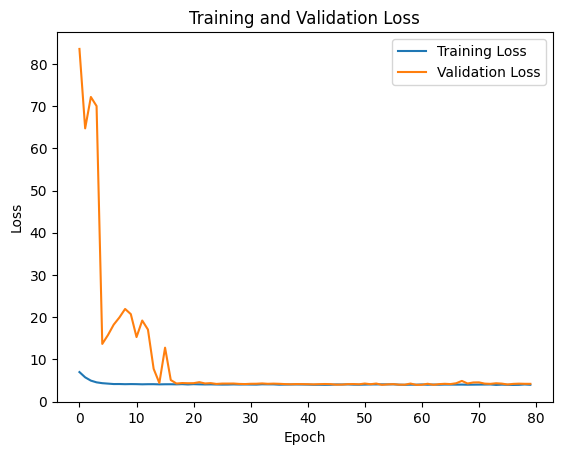

Fold 1 Results:
   MAE: 0.03962719067931175
   Average Frobenius distance: 1.8410712480545044
   Average MAE node strength: 0.6928480420739273
   Average MAE clustering coefficient: 0.07489405068046512
   Average MAE betweenness centrality: 0.2406503243008433
   Average MAE eigenvector centrality: 0.027670774426920085

Fold 2/3
Epoch 1:
  Training -> D1 Loss: 0.69180, G1 Loss: 2.77029, D2 Loss: 0.69087, G2 Loss: 2.77966
  Validation -> Loss: 98.5180
Time: 23.71s, CPU: 25.75%, Memory: 3.24GB, GPU: 0.05GB, GPU Util: 2.50%
Epoch 2:
  Training -> D1 Loss: 0.65807, G1 Loss: 2.19281, D2 Loss: 0.65883, G2 Loss: 2.16815
  Validation -> Loss: 97.3303
Time: 25.58s, CPU: 28.95%, Memory: 3.24GB, GPU: 0.05GB, GPU Util: 4.00%
Epoch 3:
  Training -> D1 Loss: 0.64789, G1 Loss: 1.82891, D2 Loss: 0.63834, G2 Loss: 1.80503
  Validation -> Loss: 95.9357
Time: 26.23s, CPU: 32.35%, Memory: 3.24GB, GPU: 0.05GB, GPU Util: 4.00%
Epoch 4:
  Training -> D1 Loss: 0.64752, G1 Loss: 1.64935, D2 Loss: 0.61299, G2 Lo

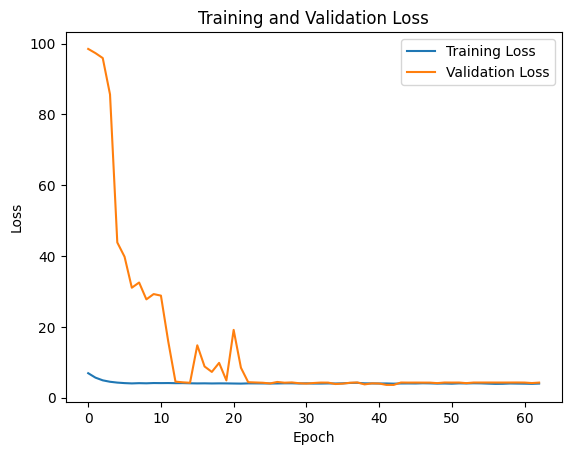

Fold 2 Results:
   MAE: 0.04051433876156807
   Average Frobenius distance: 1.8878549337387085
   Average MAE node strength: 0.6919791790182762
   Average MAE clustering coefficient: 0.08180484535601598
   Average MAE betweenness centrality: 0.22533007693435497
   Average MAE eigenvector centrality: 0.02804030160186857

Fold 3/3
Epoch 1:
  Training -> D1 Loss: 0.68828, G1 Loss: 2.73935, D2 Loss: 0.69126, G2 Loss: 2.82956
  Validation -> Loss: 73.5828
Time: 25.54s, CPU: 22.95%, Memory: 3.25GB, GPU: 0.05GB, GPU Util: 2.50%
Epoch 2:
  Training -> D1 Loss: 0.65723, G1 Loss: 2.17974, D2 Loss: 0.65950, G2 Loss: 2.22654
  Validation -> Loss: 71.8196
Time: 24.21s, CPU: 23.70%, Memory: 3.25GB, GPU: 0.05GB, GPU Util: 4.00%
Epoch 3:
  Training -> D1 Loss: 0.64892, G1 Loss: 1.82509, D2 Loss: 0.64302, G2 Loss: 1.83022
  Validation -> Loss: 54.7812
Time: 26.69s, CPU: 29.55%, Memory: 3.25GB, GPU: 0.05GB, GPU Util: 4.00%
Epoch 4:
  Training -> D1 Loss: 0.64747, G1 Loss: 1.62936, D2 Loss: 0.62735, G2 Lo

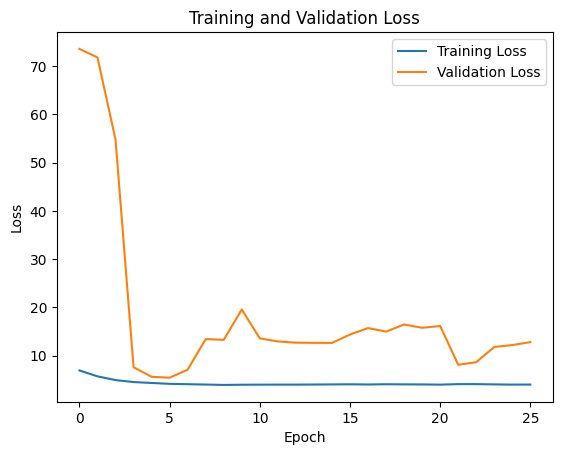

Fold 3 Results:
   MAE: 0.05210006237030029
   Average Frobenius distance: 2.4110374450683594
   Average MAE node strength: 1.007484852866866
   Average MAE clustering coefficient: 0.0680312020135383
   Average MAE betweenness centrality: 0.243258019461228
   Average MAE eigenvector centrality: 0.03299588947952782

Cross-Validation Results:
mae: Mean = 0.0441 ± 0.01
frobenius_distance: Mean = 2.0467 ± 0.26
mae_ns: Mean = 0.7974 ± 0.15
mae_cc: Mean = 0.0749 ± 0.01
mae_bc: Mean = 0.2364 ± 0.01
mae_ec: Mean = 0.0296 ± 0.00
epochs: Mean = 200.0000 ± 0.00
training_times: Mean = 1410.5009 ± 539.39
avg_memory_usage: Mean = 3.2404 ± 0.01
avg_gpu_usage: Mean = 0.0486 ± 0.00
max_memory_usage: Mean = 3.2415 ± 0.01
max_gpu_usage: Mean = 0.0486 ± 0.00


In [7]:
conv_size = simulated_adj_train.shape[2]
hidden_size = conv_size*conv_size

simulated_generator1 = EvoGenerator(conv_size, hidden_size).to(device)
simulated_discriminator1 = EvoDiscriminator(conv_size, hidden_size).to(device)
simulated_generator2 = EvoGenerator(conv_size, hidden_size).to(device)
simulated_discriminator2 = EvoDiscriminator(conv_size, hidden_size).to(device)

print(simulated_generator1)
print(simulated_discriminator1)
n_generator_param = simulated_generator1.count_parameters()
n_discriminator_param = simulated_discriminator1.count_parameters()
n_evograph_param = n_generator_param + n_discriminator_param
print(f"Total number of trainable parameters: {n_evograph_param*2}\n")

# Train model 
avg_metrics, std_metrics = train_test_cv_evograph(simulated_generator1, simulated_discriminator1, 
            simulated_generator2, simulated_discriminator2,
            simulated_features, simulated_adj,
            num_epochs=200, lr_d=0.01, lr_g=0.01, step_size=50, gamma=0.5, 
            save_path="models/evograph_simulated", patience=20)

## OASIS

EvoGenerator(
  (conv1): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=1225, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(35)
  (conv2): NNConv(35, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
  (conv3): NNConv(1, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv33): BatchNorm(35)
)
EvoDiscriminator(
  (conv1): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=1225, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(35)
  (conv2): NNConv(35, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
)
Total number of trainable parameters: 18492


Fold 1/3
Epoch 1:
  Training -> D1 Loss: 0.69157, G1 Loss: 2.57165, D2 Loss: 0.68833, G2 Loss: 2.85486
  Validation -> Loss: 34.0

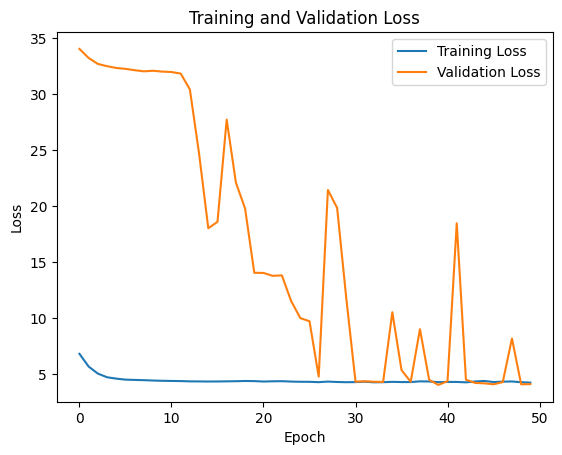

Fold 1 Results:
   MAE: 0.060420144349336624
   Average Frobenius distance: 2.980184555053711
   Average MAE node strength: 1.1383733613364688
   Average MAE clustering coefficient: 0.06787966455393761
   Average MAE betweenness centrality: 0.08054165292294035
   Average MAE eigenvector centrality: 0.03021009165837149

Fold 2/3
Epoch 1:
  Training -> D1 Loss: 0.68249, G1 Loss: 2.56105, D2 Loss: 0.68769, G2 Loss: 2.83101
  Validation -> Loss: 12.6152
Time: 28.98s, CPU: 26.10%, Memory: 3.26GB, GPU: 0.05GB, GPU Util: 2.00%
Epoch 2:
  Training -> D1 Loss: 0.65155, G1 Loss: 2.06558, D2 Loss: 0.65215, G2 Loss: 2.32069
  Validation -> Loss: 11.8857
Time: 29.70s, CPU: 30.85%, Memory: 3.26GB, GPU: 0.05GB, GPU Util: 4.00%
Epoch 3:
  Training -> D1 Loss: 0.63845, G1 Loss: 1.77021, D2 Loss: 0.63487, G2 Loss: 2.01713
  Validation -> Loss: 4.7291
Time: 28.59s, CPU: 21.45%, Memory: 3.26GB, GPU: 0.05GB, GPU Util: 4.00%
Epoch 4:
  Training -> D1 Loss: 0.64080, G1 Loss: 1.59157, D2 Loss: 0.62107, G2 Los

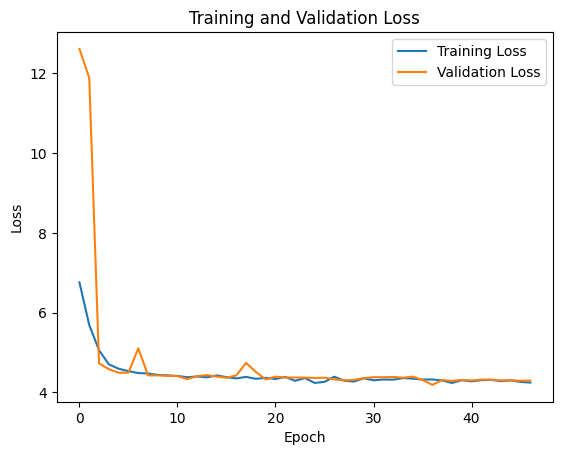

Fold 2 Results:
   MAE: 0.051775045692920685
   Average Frobenius distance: 2.3488619327545166
   Average MAE node strength: 0.9549172654231861
   Average MAE clustering coefficient: 0.05791455199371312
   Average MAE betweenness centrality: 0.08222361815561144
   Average MAE eigenvector centrality: 0.03013098312835552

Fold 3/3
Epoch 1:
  Training -> D1 Loss: 0.68890, G1 Loss: 2.55731, D2 Loss: 0.69241, G2 Loss: 2.53562
  Validation -> Loss: 62.6538
Time: 31.36s, CPU: 27.20%, Memory: 3.26GB, GPU: 0.05GB, GPU Util: 2.50%
Epoch 2:
  Training -> D1 Loss: 0.65272, G1 Loss: 2.05702, D2 Loss: 0.65854, G2 Loss: 2.02180
  Validation -> Loss: 62.2483
Time: 30.03s, CPU: 27.90%, Memory: 3.26GB, GPU: 0.05GB, GPU Util: 3.00%
Epoch 3:
  Training -> D1 Loss: 0.64516, G1 Loss: 1.74333, D2 Loss: 0.64938, G2 Loss: 1.71304
  Validation -> Loss: 68.1683
Time: 31.18s, CPU: 29.80%, Memory: 3.26GB, GPU: 0.05GB, GPU Util: 3.50%
Epoch 4:
  Training -> D1 Loss: 0.64559, G1 Loss: 1.61886, D2 Loss: 0.63886, G2 L

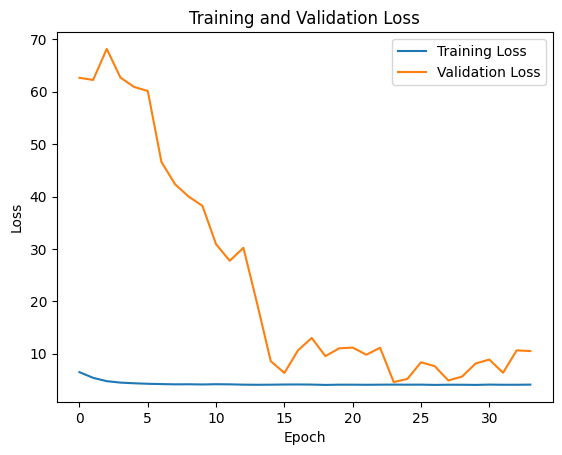

Fold 3 Results:
   MAE: 0.18587522208690643
   Average Frobenius distance: 20.730876922607422
   Average MAE node strength: 5.342138316514487
   Average MAE clustering coefficient: 0.07637145673152645
   Average MAE betweenness centrality: 0.08151507220890238
   Average MAE eigenvector centrality: 0.03301823161952775

Cross-Validation Results:
mae: Mean = 0.0994 ± 0.06
frobenius_distance: Mean = 8.6866 ± 8.52
mae_ns: Mean = 2.4785 ± 2.03
mae_cc: Mean = 0.0674 ± 0.01
mae_bc: Mean = 0.0814 ± 0.00
mae_ec: Mean = 0.0311 ± 0.00
epochs: Mean = 200.0000 ± 0.00
training_times: Mean = 1349.9211 ± 179.21
avg_memory_usage: Mean = 3.2563 ± 0.00
avg_gpu_usage: Mean = 0.0489 ± 0.00
max_memory_usage: Mean = 3.2563 ± 0.00
max_gpu_usage: Mean = 0.0489 ± 0.00


In [8]:
conv_size = oasis_adj_train.shape[2]
hidden_size = conv_size*conv_size

oasis_generator1 = EvoGenerator(conv_size, hidden_size).to(device)
oasis_discriminator1 = EvoDiscriminator(conv_size, hidden_size).to(device)
oasis_generator2 = EvoGenerator(conv_size, hidden_size).to(device)
oasis_discriminator2 = EvoDiscriminator(conv_size, hidden_size).to(device)

print(oasis_generator1)
print(oasis_discriminator1)
n_generator_param = oasis_generator1.count_parameters()
n_discriminator_param = oasis_discriminator1.count_parameters()
n_evograph_param = n_generator_param + n_discriminator_param
print(f"Total number of trainable parameters: {n_evograph_param*2}\n")

# Train model 
avg_metrics, std_metrics = train_test_cv_evograph(oasis_generator1, oasis_discriminator1, oasis_generator2, oasis_discriminator2,
            oasis_features, oasis_adj, num_epochs=200, lr_d=0.01, lr_g=0.01, 
            step_size=50, gamma=0.5, patience=10, save_path="models/evograph_oasis")

## EMCI-AD

EvoGenerator(
  (conv1): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=1225, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(35)
  (conv2): NNConv(35, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
  (conv3): NNConv(1, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv33): BatchNorm(35)
)
EvoDiscriminator(
  (conv1): NNConv(35, 35, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=1225, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(35)
  (conv2): NNConv(35, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=35, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
)
Total number of trainable parameters: 18492


Fold 1/3


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1:
  Training -> D1 Loss: 0.70200, G1 Loss: 2.29706, D2 Loss: 0.00000, G2 Loss: 0.00000
  Validation -> Loss: 2.6302
Time: 10.91s, CPU: 29.40%, Memory: 3.26GB, GPU: 0.03GB, GPU Util: 1.00%
Epoch 2:
  Training -> D1 Loss: 0.66848, G1 Loss: 2.25934, D2 Loss: 0.00000, G2 Loss: 0.00000
  Validation -> Loss: 2.5409
Time: 11.74s, CPU: 36.30%, Memory: 3.26GB, GPU: 0.03GB, GPU Util: 1.50%
Epoch 3:
  Training -> D1 Loss: 0.65844, G1 Loss: 2.22682, D2 Loss: 0.00000, G2 Loss: 0.00000
  Validation -> Loss: 2.5404
Time: 10.27s, CPU: 27.10%, Memory: 3.26GB, GPU: 0.03GB, GPU Util: 3.50%
Epoch 4:
  Training -> D1 Loss: 0.63895, G1 Loss: 2.20219, D2 Loss: 0.00000, G2 Loss: 0.00000
  Validation -> Loss: 2.5901
Time: 11.58s, CPU: 24.90%, Memory: 3.26GB, GPU: 0.03GB, GPU Util: 3.50%
Epoch 5:
  Training -> D1 Loss: 0.62262, G1 Loss: 2.18332, D2 Loss: 0.00000, G2 Loss: 0.00000
  Validation -> Loss: 2.5962
Time: 11.64s, CPU: 25.60%, Memory: 3.26GB, GPU: 0.03GB, GPU Util: 1.50%
Epoch 6:
  Training -> D1

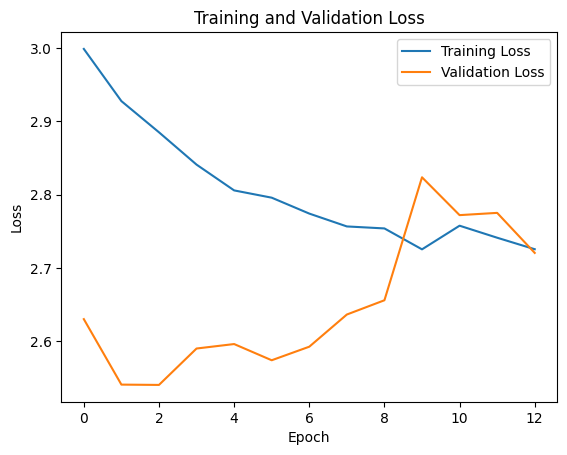

Fold 1 Results:
   MAE: 0.4360782206058502
   Average Frobenius distance: 24.1790828704834
   Average MAE node strength: 11.018922233566945
   Average MAE clustering coefficient: 0.23233836949783224
   Average MAE betweenness centrality: 0.09725846708934767
   Average MAE eigenvector centrality: 0.027789885785129306

Fold 2/3


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1:
  Training -> D1 Loss: 0.69313, G1 Loss: 2.29409, D2 Loss: 0.00000, G2 Loss: 0.00000
  Validation -> Loss: 2.6433
Time: 11.76s, CPU: 24.40%, Memory: 3.26GB, GPU: 0.03GB, GPU Util: 1.00%
Epoch 2:
  Training -> D1 Loss: 0.66422, G1 Loss: 2.25673, D2 Loss: 0.00000, G2 Loss: 0.00000
  Validation -> Loss: 2.5927
Time: 10.14s, CPU: 24.80%, Memory: 3.26GB, GPU: 0.03GB, GPU Util: 2.50%
Epoch 3:
  Training -> D1 Loss: 0.65360, G1 Loss: 2.21853, D2 Loss: 0.00000, G2 Loss: 0.00000
  Validation -> Loss: 2.6090
Time: 12.13s, CPU: 32.40%, Memory: 3.26GB, GPU: 0.03GB, GPU Util: 3.50%
Epoch 4:
  Training -> D1 Loss: 0.64409, G1 Loss: 2.20114, D2 Loss: 0.00000, G2 Loss: 0.00000
  Validation -> Loss: 2.5790
Time: 12.07s, CPU: 34.20%, Memory: 3.26GB, GPU: 0.03GB, GPU Util: 3.00%
Epoch 5:
  Training -> D1 Loss: 0.62373, G1 Loss: 2.20592, D2 Loss: 0.00000, G2 Loss: 0.00000
  Validation -> Loss: 2.5817
Time: 9.47s, CPU: 16.20%, Memory: 3.26GB, GPU: 0.03GB, GPU Util: 2.50%
Epoch 6:
  Training -> D1 

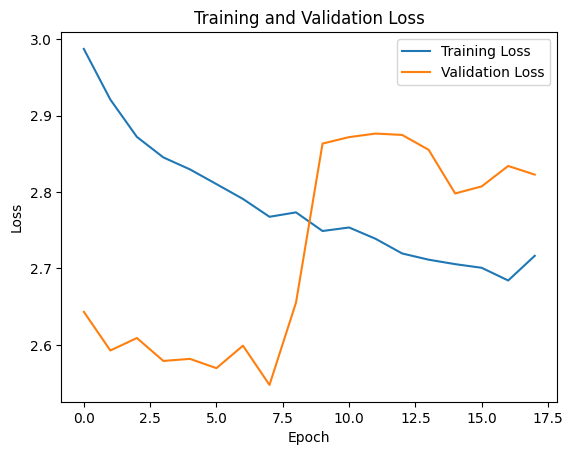

Fold 2 Results:
   MAE: 0.4029192328453064
   Average Frobenius distance: 22.852006912231445
   Average MAE node strength: 10.818631155697885
   Average MAE clustering coefficient: 0.21164827790060461
   Average MAE betweenness centrality: 0.09334901453694426
   Average MAE eigenvector centrality: 0.019914359287187974

Fold 3/3


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1:
  Training -> D1 Loss: 0.69124, G1 Loss: 2.28383, D2 Loss: 0.00000, G2 Loss: 0.00000
  Validation -> Loss: 2.6666
Time: 11.90s, CPU: 27.35%, Memory: 3.26GB, GPU: 0.03GB, GPU Util: 0.50%
Epoch 2:
  Training -> D1 Loss: 0.66325, G1 Loss: 2.24032, D2 Loss: 0.00000, G2 Loss: 0.00000
  Validation -> Loss: 2.6274
Time: 11.27s, CPU: 32.80%, Memory: 3.26GB, GPU: 0.03GB, GPU Util: 1.50%
Epoch 3:
  Training -> D1 Loss: 0.65833, G1 Loss: 2.21606, D2 Loss: 0.00000, G2 Loss: 0.00000
  Validation -> Loss: 2.6277
Time: 11.92s, CPU: 34.95%, Memory: 3.26GB, GPU: 0.03GB, GPU Util: 1.00%
Epoch 4:
  Training -> D1 Loss: 0.63791, G1 Loss: 2.18258, D2 Loss: 0.00000, G2 Loss: 0.00000
  Validation -> Loss: 2.6032
Time: 11.87s, CPU: 37.80%, Memory: 3.26GB, GPU: 0.03GB, GPU Util: 1.50%
Epoch 5:
  Training -> D1 Loss: 0.63119, G1 Loss: 2.17566, D2 Loss: 0.00000, G2 Loss: 0.00000
  Validation -> Loss: 2.6241
Time: 9.98s, CPU: 27.60%, Memory: 3.26GB, GPU: 0.03GB, GPU Util: 3.50%
Epoch 6:
  Training -> D1 

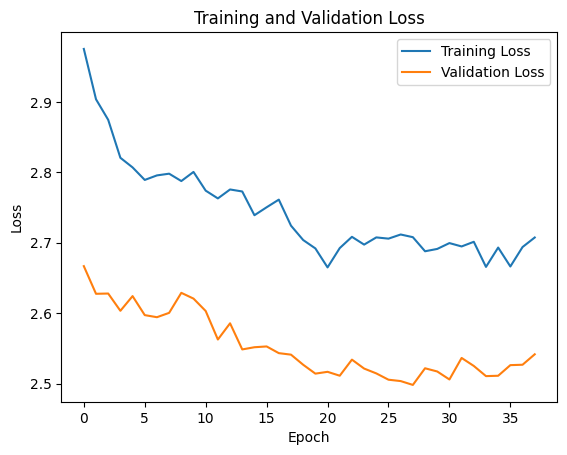

Fold 3 Results:
   MAE: 0.4014436602592468
   Average Frobenius distance: 22.92429542541504
   Average MAE node strength: 11.522220727100095
   Average MAE clustering coefficient: 0.1877401733291432
   Average MAE betweenness centrality: 0.08415016144198727
   Average MAE eigenvector centrality: 0.018550885061364417

Cross-Validation Results:
mae: Mean = 0.4135 ± 0.02
frobenius_distance: Mean = 23.3185 ± 0.61
mae_ns: Mean = 11.1199 ± 0.30
mae_cc: Mean = 0.2106 ± 0.02
mae_bc: Mean = 0.0916 ± 0.01
mae_ec: Mean = 0.0221 ± 0.00
epochs: Mean = 200.0000 ± 0.00
training_times: Mean = 260.2912 ± 124.42
avg_memory_usage: Mean = 3.2600 ± 0.00
avg_gpu_usage: Mean = 0.0326 ± 0.00
max_memory_usage: Mean = 3.2600 ± 0.00
max_gpu_usage: Mean = 0.0326 ± 0.00


In [9]:
conv_size = emci_adj_train.shape[2]
hidden_size = conv_size*conv_size

emci_generator1 = EvoGenerator(conv_size, hidden_size).to(device)
emci_discriminator1 = EvoDiscriminator(conv_size, hidden_size).to(device)
emci_generator2 = EvoGenerator(conv_size, hidden_size).to(device)
emci_discriminator2 = EvoDiscriminator(conv_size, hidden_size).to(device)

print(emci_generator1)
print(emci_discriminator1)
n_generator_param = emci_generator1.count_parameters()
n_discriminator_param = emci_discriminator1.count_parameters()
n_evograph_param = n_generator_param + n_discriminator_param
print(f"Total number of trainable parameters: {n_evograph_param*2}\n")

# Train model 
avg_metrics, std_metrics = train_test_cv_evograph(emci_generator1, emci_discriminator1, emci_generator2, emci_discriminator2,
            emci_features, emci_adj, num_epochs=200, lr_d=0.01, lr_g=0.01, 
            step_size=50, gamma=0.5, patience=10, save_path="models/evograph_emci")

## SLIM160

In [20]:
conv_size = slim160_adj_train.shape[2]
hidden_size = conv_size*conv_size

slim160_generator1 = EvoGenerator(conv_size, hidden_size).to(device)
slim160_discriminator1 = EvoDiscriminator(conv_size, hidden_size).to(device)
slim160_generator2 = EvoGenerator(conv_size, hidden_size).to(device)
slim160_discriminator2 = EvoDiscriminator(conv_size, hidden_size).to(device)

print(slim160_generator1)
print(slim160_discriminator1)
n_generator_param = slim160_generator1.count_parameters()
n_discriminator_param = slim160_discriminator1.count_parameters()
n_evograph_param = n_generator_param + n_discriminator_param
print(f"Total number of trainable parameters: {n_evograph_param*2}\n")

# Train model 
train_evograph(slim160_generator1, slim160_discriminator1, slim160_generator2, slim160_discriminator2,
            slim160_adj_train, slim160_adj_val, num_epochs=100, lr_d=0.001, lr_g=0.001, 
            step_size=50, gamma=0.1, save_path="models/evograph_slim160")

EvoGenerator(
  (conv1): NNConv(160, 160, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=25600, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(160)
  (conv2): NNConv(160, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=160, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
  (conv3): NNConv(1, 160, aggr=mean, nn=Sequential(
    (0): Linear(in_features=1, out_features=160, bias=True)
    (1): ReLU()
  ))
  (conv33): BatchNorm(160)
)
EvoDiscriminator(
  (conv1): NNConv(160, 160, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=25600, bias=True)
    (1): ReLU()
  ))
  (conv11): BatchNorm(160)
  (conv2): NNConv(160, 1, aggr=mean, nn=Sequential(
    (0): Linear(in_features=2, out_features=160, bias=True)
    (1): ReLU()
  ))
  (conv22): BatchNorm(1)
)
Total number of trainable parameters: 364492



OutOfMemoryError: CUDA out of memory. Tried to allocate 2.44 GiB. GPU 0 has a total capacty of 15.89 GiB of which 390.69 MiB is free. Process 2513351 has 15.51 GiB memory in use. Of the allocated memory 12.53 GiB is allocated by PyTorch, and 2.37 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF